---
title: "Fine-Tuning Kodis Analysis"
author: "Michelle Gelman"
date: "05/15/2025"
format: 
  html:
    toc: true
    code-fold: true
    execute:
      eval: false
      echo: True
      cache: True
jupyter: python3
---

In [4]:

from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import pprint as pp
from IPython.display import display
import torch
import pickle
import random
from pathlib import Path 
import json
import re
from collections import defaultdict
from scipy.stats import entropy
import ast
from collections import defaultdict
import importlib
import torch
import os
from pathlib import Path
from datetime import datetime
import json
import torch
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)
from modules.DataPreprocesser import DataPreprocesser
from modules import CorpusUtils as corp
#Convokit Imports
from convokit.forecaster.CRAFTModel import CRAFTModel
from convokit.forecaster.forecaster import Forecaster
from convokit import download, Corpus
from convokit import Corpus, Speaker, Utterance, Conversation
from functools import partial
from convokit.convokitConfig import ConvoKitConfig

In [203]:
downpath =Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/downsampled_run/corpus_kodis_ground_downsampled")
defaultpath =Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/nosampling_run/corpus_kodis_ground_default")
weights_path = Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/weighted_run/corpus_kodis_ground_weighted_loss")

corpus_down = Corpus(filename=downpath)
corpus_default = Corpus(filename=defaultpath)
corpus_weighted = Corpus(filename=weights_path)

# Fine-Tuning Configuration:
- [Forecaster Model]()

### **1. Data & Splits**
- Corpus: 2,107 buyer–seller disputes. No AI. 
- Train/Val/Test: 60/20/20 split (≈ 1,264 / 421 / 421 conversations). 
    - random-seed: 42 (for reproducibility)

### **2. Model Configuration**
#### **Total models fine-tuned:** 9 (3x3) fine-tuned model configurations, paired as (imbalance variant x context-selection)
#### **Baseline fine-tuned:** Pre-trained wiki fine-tuned model
- Base model parameters: pre-wiki trained CRAFT model
- vocabulary size (tokenization):  [50004: it was built using a fixed vocab size of 50k plus 4 spots for special tokens PAD, SOS, EOS, and UNK](https://colab.research.google.com/drive/1GvICZN0VwZQSWw3pJaEVY-EQGoO-L5lH?utm_source=chatgpt.com)
- Conversation-selection Training Logic: last context-tuple (entire conversation history up to last utterance) for all conversations


**DEFAULT_CONFIG from CRAFT backend**

| **Parameter**    | **Value** |
| ---------------- | --------- |
| dropout          | 0.1       |
| batch\_size      | 64        |
| clip             | 50.0      |
| learning\_rate   | 1e-5      |
| print\_every     | 10        |
| finetune\_epochs | 30        |
| validation\_size | 0.2       |
#### **2.1. Training Set Preprocessing Variants**

| **Variant**           | **Description**                                                                               |
| --------------------- | --------------------------------------------------------------------------------------------- |
| **Ground**            | All utterances up to (and including) the final one marked as derailment                       |
| **No‑Last**           | All utterances except the final comment (i.e. drop the last utterance)                        |
| **No‑Last‑No‑Submit** | As **No‑Last**, plus remove any “Submitted agreement” system messages from the remaining text |
#### **2.2. Class Imbalance Variants Variants**



| Regime          | Loss                                                                        | Sampling                                                |
| --------------- | --------------------------------------------------------------------------- | ------------------------------------------------------- |
| **Default**     | Standard binary cross‐entropy (BCE)                                         | Original class imbalance (\~371 derail vs. 1,734 clean) |
| **Weighted**    | BCE with class‐weighted loss (higher weight on the minority “derail” class) | Original class imbalance (\~371 derail vs. 1,734 clean) |
| **Downsampled** | BCE, but training set downsampled to a 1:1 class ratio                      | 371 / 371 train examples                                |


### **3. Forecaster Training Configuration**
#### **Number of Runs**: 9 total. 1 for each variant with same train/test/split seed (42)
- **Forecaster:** uses CRAFT Backend, writes conversation.meta["prediction"] (0/1) and meta["pred_score"] (probability) for all utterances in training set variants
- **Default threshold:** 0.54 for binary decision in any utterance to classifiy conversation as impasse (1)
- **Optimized threshold**: per‐variant “best” threshold chosen via Youden’s J (maximize TPR – FPR) on the test set from conversation-level AUC/PR Curves across variants

### **5. Evaluation & Aggregation**
#### **Evaluation:** Test Set (421 Convsersations). Uses Original Ground Variant.

#### **5.1. Initial Analysis**
- Accuracy, Precision, Recall (TPR), FPR, F1
- AUC / PR curves (using max pred_score from each conversation)
- Horizon plots: aggregate utterance‐position forecast scores to visualize how early derailment is detected.

#### **5.2. Secondary Analysis**
- **Best‐Threshold Performance**(accuracy, TPR, FPR, F1, J index, threshold)
- **Probability Evolution Trends Over Conversational Contexts:** Overlay variants (Default / Weighted / Downsampled / Wiki) for each context.
- **Self‑report Avg. Frustration CVorrelation with Max Prediction:** Pearson r and linear regression (R²) Between each convo’s max_pred_score (highest utterance probability) and its avg_frustration_score.
- **Probability Score Distribution:** Explore sensitivity of probability scores across utterances for models, controlling for imbalance or training set variants
- **Fighing Words:** Comparing [Fighting words](https://www.cambridge.org/core/journals/political-analysis/article/fightin-words-lexical-feature-selection-and-evaluation-for-identifying-the-content-of-political-conflict/81B3703230D21620B81EB6E2266C7A66) between Misclassified True Derailed Conversations class and Correctly Classified Successful Conversations class
    - Comparing n-gram log-odds ratio versus frequency of word on per utterance and per conversation basis
    - Using vocabulary generated stricly from all classes (not entire corpus). Default prior (occ. of n-gram) set to .1 as default
    - Y-axis: Prevalance of word within the Class. negative = class2, positive = class1
    - X- axis: Occurence of n-gram within associated class.
    - Z-score: tells you how many “standard deviations” away from zero the log‑odds difference is. Comparing “class 1 vs. class 2” directly

# Current Interpretation:
- Want to know how to better analyze mispredictions 
    - Fighting Words unclear still. Tried training vocabulary both on entire corpus and on just chosesn TP/FP/TN/FP Subsets. Vary n-gram (length of phrases). Unsure about whether or not to include stopping_words or use priors from entire corpus

- Ground wiki picked up high best decision threshold (.88), while most others around .55-.75
- No submit no last variants most similar to ground_wiki in terms of confusion matrix and metrics(theshold as well, .75)
- Weighted variants overfitting I think. All Impasse mispredicted as success.
- No last no submit closest to ground wiki model. Also has similar utterance aggregtaed prediction score trends across impasse and success dialogues
- The few downsampling training runs had high accuracy variablitiy (27% to 80%) meaning fine-tuning is not entirely reproducible despite controlling for same training/test/split 
- AUC/PR curved looked good (better than baseline for all model)
- caviaates to having high prediction threshold?

## Goals:
- Define conference target and paper goals to guide interpretation and futher testing
- Define characteristics of derailment for dispute-type dialogues
- What does the model pick up in a dispute to forecast derailment when predicting probability over-time

## Improvement Considerations:
- Including Learning‑rate scheduling or early stopping  to stop training early when it converges to prevent overfitting/underfitting
- full-end to end training with testing model_config parameters to improve metrics


## Design Decisions:
- Do we include submit agreements or no? Lose out on potential dispute dynamics with chains of submit agreements
- test on ground kodis conversations?
- Revalant Analysis considerations?
- Establishing a baseline for expcted predicted probability trends based on articats in success/dispute convos
- Sentiment granularity: comparing utterance level predicitons with conversational-level self-report scores
- predicting SVI (self, fairness, outcome, relationships). Predict Frustration?

## TODO:
- [ ] Go over CARC tutortial + set up GPU
- [ ] Predict SVI (relationships, frustration, outcome, impasse)
- [ ] Establish goals for publicaiton + applicaitions of forecaster as next steps? 

# Comparison of Metrics for all Model variants using Best Threshhold


In [23]:
%%capture
ground_thresholds, ground_metrics, ground_corpora = compare_craft_models(corpora_info_ground)
no_last_thresholds, no_last_metrics, no_last_corpora = compare_craft_models(corpora_info_no_last)
no_subm_thresholds, no_subm_metrics, no_subm_corpora = compare_craft_models(corpora_info_no_subm)

== Conversation‑level Best Threshold Test Set Metrics ==


,Accuracy,Precision,Recall,FPR,F1,Best Threshold
GROUND_DEFAULT,1.000000,1.000000,1.000000,0.000000,1.000000,0.541032
GROUND_WEIGHTED,0.827014,0.000000,0.000000,0.000000,0.000000,0.575249
GROUND_DOWNSAMPLED,0.850711,0.556818,0.671233,0.111748,0.608696,0.580783
GROUND_WIKI,0.749409,0.374046,0.671233,0.234286,0.480392,0.885502
NO_LAST_DEFAULT,0.535545,0.226667,0.698630,0.498567,0.342282,0.555385
NO_LAST_WEIGHTED,0.827014,0.000000,0.000000,0.000000,0.000000,0.576696
NO_LAST_DOWNSAMPLED,0.431280,0.218855,0.890411,0.664756,0.351351,0.559719
NO_LAST_SUBMIT_DEFAULT,0.696682,0.337278,0.780822,0.320917,0.471074,0.521406
NO_LAST_SUBMIT_WEIGHTED,0.739336,0.366906,0.698630,0.252149,0.481132,0.497068
NO_LAST_SUBMIT_DOWNSAMPLED,0.765403,0.404412,0.753425,0.232092,0.526316,0.757998


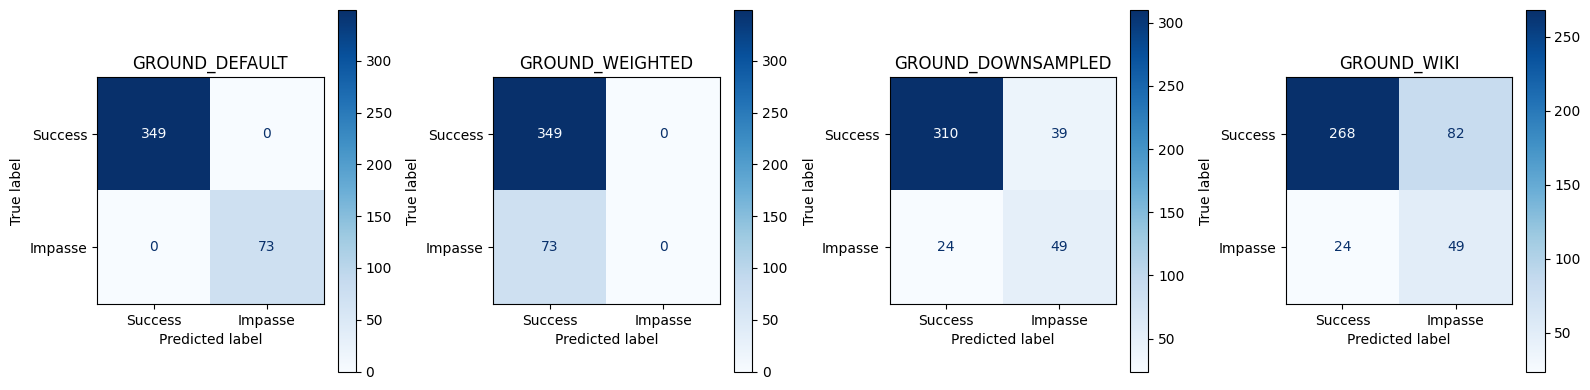

<Figure size 640x480 with 0 Axes>

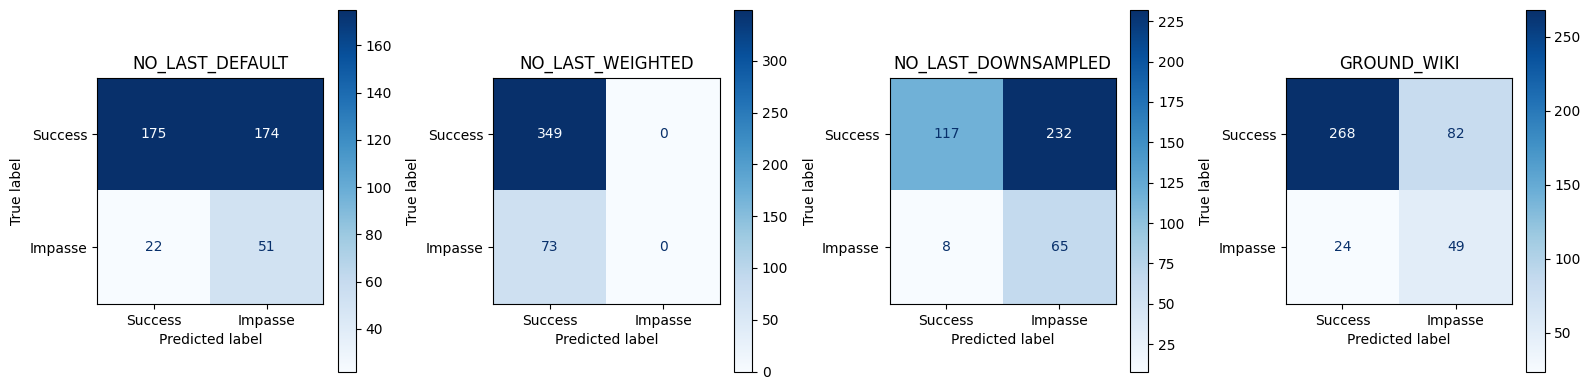

<Figure size 640x480 with 0 Axes>

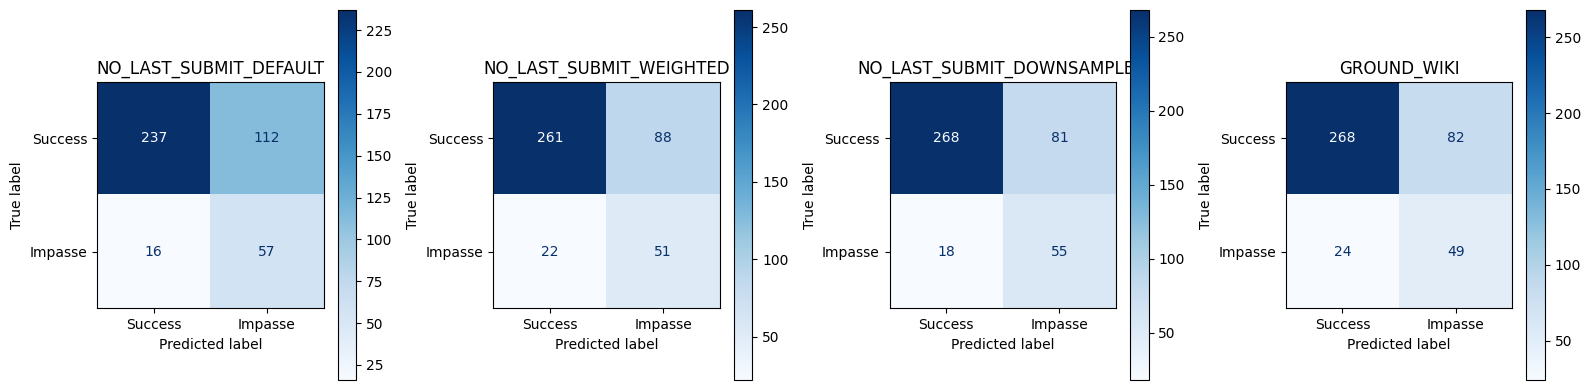

<Figure size 640x480 with 0 Axes>

In [24]:
allmetrics = {}
allmetrics.update(ground_metrics)
allmetrics.update(no_last_metrics)
allmetrics.update(no_subm_metrics)
allcorpora = {}
allcorpora.update(ground_corpora)
allcorpora.update(no_last_corpora)
allcorpora.update(no_subm_corpora)

compare_best_model_metrics(allmetrics, ground_corpora)

compare_best_model_confusion(ground_thresholds, ground_metrics, ground_corpora)
compare_best_model_confusion(no_last_thresholds, ground_metrics,  no_last_corpora)
compare_best_model_confusion( no_subm_thresholds, no_subm_metrics, no_subm_corpora)

# Differences in Distributed Probabilities 

In [68]:
all_corpora_by_downsampling_comp = [corpora_info_ground, corpora_info_no_last, corpora_info_no_subm]
all_corpora_by_utterance_comp = [corpora_info_no_sampling, corpora_info_downsampled, corpora_info_weighted]



### Model Sensitivity of Probability Forecast to Downsampling

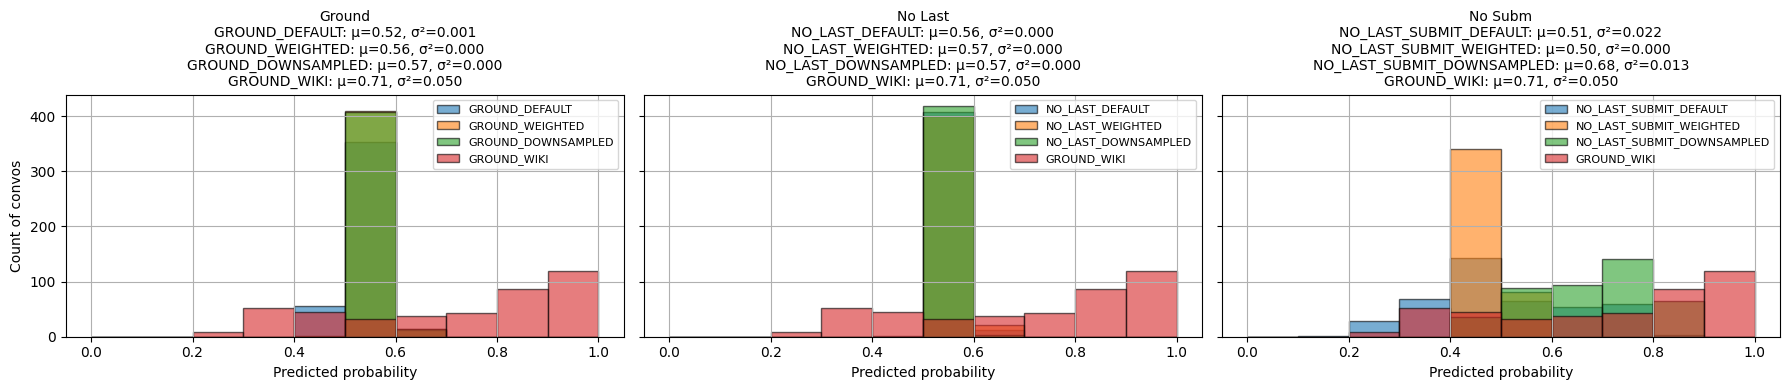

In [69]:
compare_best_model_convo_histograms(all_corpora_by_downsampling_comp, title_key=1)

### Model Sensitivity of Probability Forecast to Utterance Variability

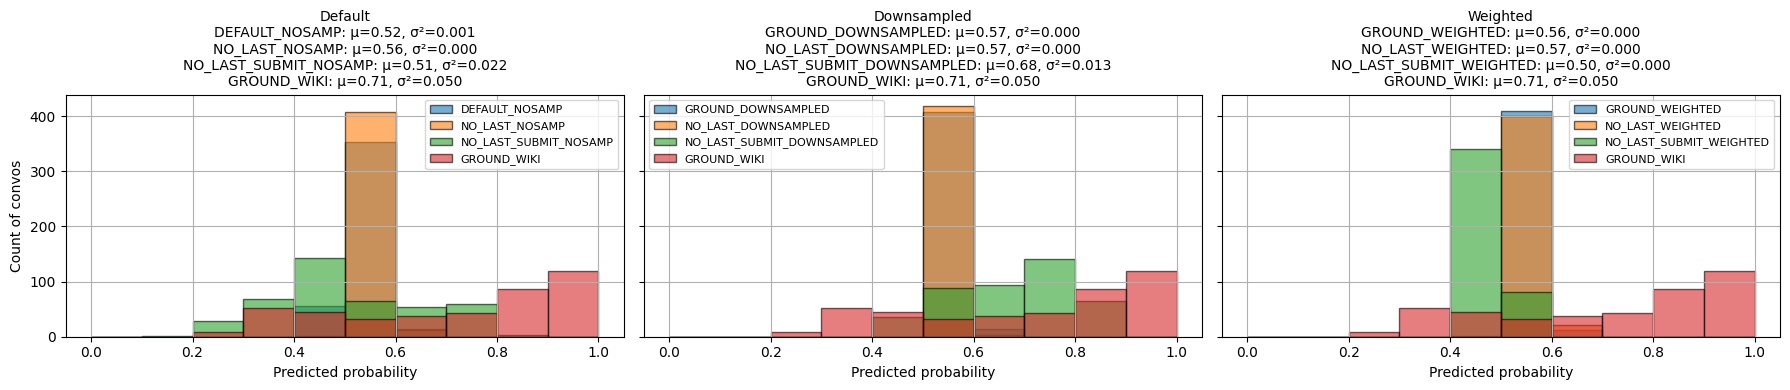

In [206]:
compare_best_model_convo_histograms(all_corpora_by_utterance_comp, title_key=0)


# Misclassified Texts Analysis: No Last Utterance No Submit with Downsampling

In [25]:

no_last_downsampled_mispred = Corpus(filename='/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/downsampled_run/corpus_kodis_no_last_downsampled')
no_last_downsampled_mispred = no_last_downsampled_mispred.filter_conversations_by(selector= convo_selector)
apply_best_threshold(no_last_downsampled_mispred, threshold=0.5597192049026489)
no_last_downsampled_mispred= no_last_downsampled_mispred.filter_conversations_by(
    lambda convo: convo.meta.get("best_forecast") != convo.meta.get("label"))

no_last_downsampled_true = Corpus(filename='/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/downsampled_run/corpus_kodis_no_last_downsampled')
no_last_downsampled_true = no_last_downsampled_true.filter_conversations_by(selector= convo_selector)
apply_best_threshold(no_last_downsampled_true, threshold=0.5597192049026489)
no_last_downsampled_true= no_last_downsampled_true.filter_conversations_by(
    lambda convo: convo.meta.get("best_forecast") == convo.meta.get("label"))


### Example Misclassified Conversation

In [27]:
print_conversation(no_last_downsampled_mispred, "utt0_con67")

Buyer_67: You know the site was advertising a Kobe Bryant jersey so that's what I should be still entitled to receive.
Seller_67: Hello, I'm sorry but I think there was misunderstanding. The jersey that I was selling wasn't for any particular player.
Buyer_67: You had originally stated that it was a Bryant jersey, no one would have bought it for the second rate player that is on the jersey you set me.
Seller_67: I never stated that, nor have I ever talked to you. You simply purchased the jersey and I sent it to you. I am willing to work with you if you're that unhappy, but you have to understand where I am coming from too.
Buyer_67: The advertising stated that I know I wasn't talking to you directly are you willing to refund me for the purchase?
Seller_67: No, I can't refund you. You purchased the jersey under the listing that never stated any particular name. Are you able to review the listing again?
Buyer_67: You've conveniently altered the listing so that it indicates no specific pl

### Fighting Words Analysis Example: False Derailment vs True Sucess for No Last No Submit Agreement Downsampled Model (Utterance Level)

class1_func returned 3157 valid corpus components. class2_func returned 1369 valid corpus components.
Vocab size is 684
Comparing language...
ngram zscores computed.


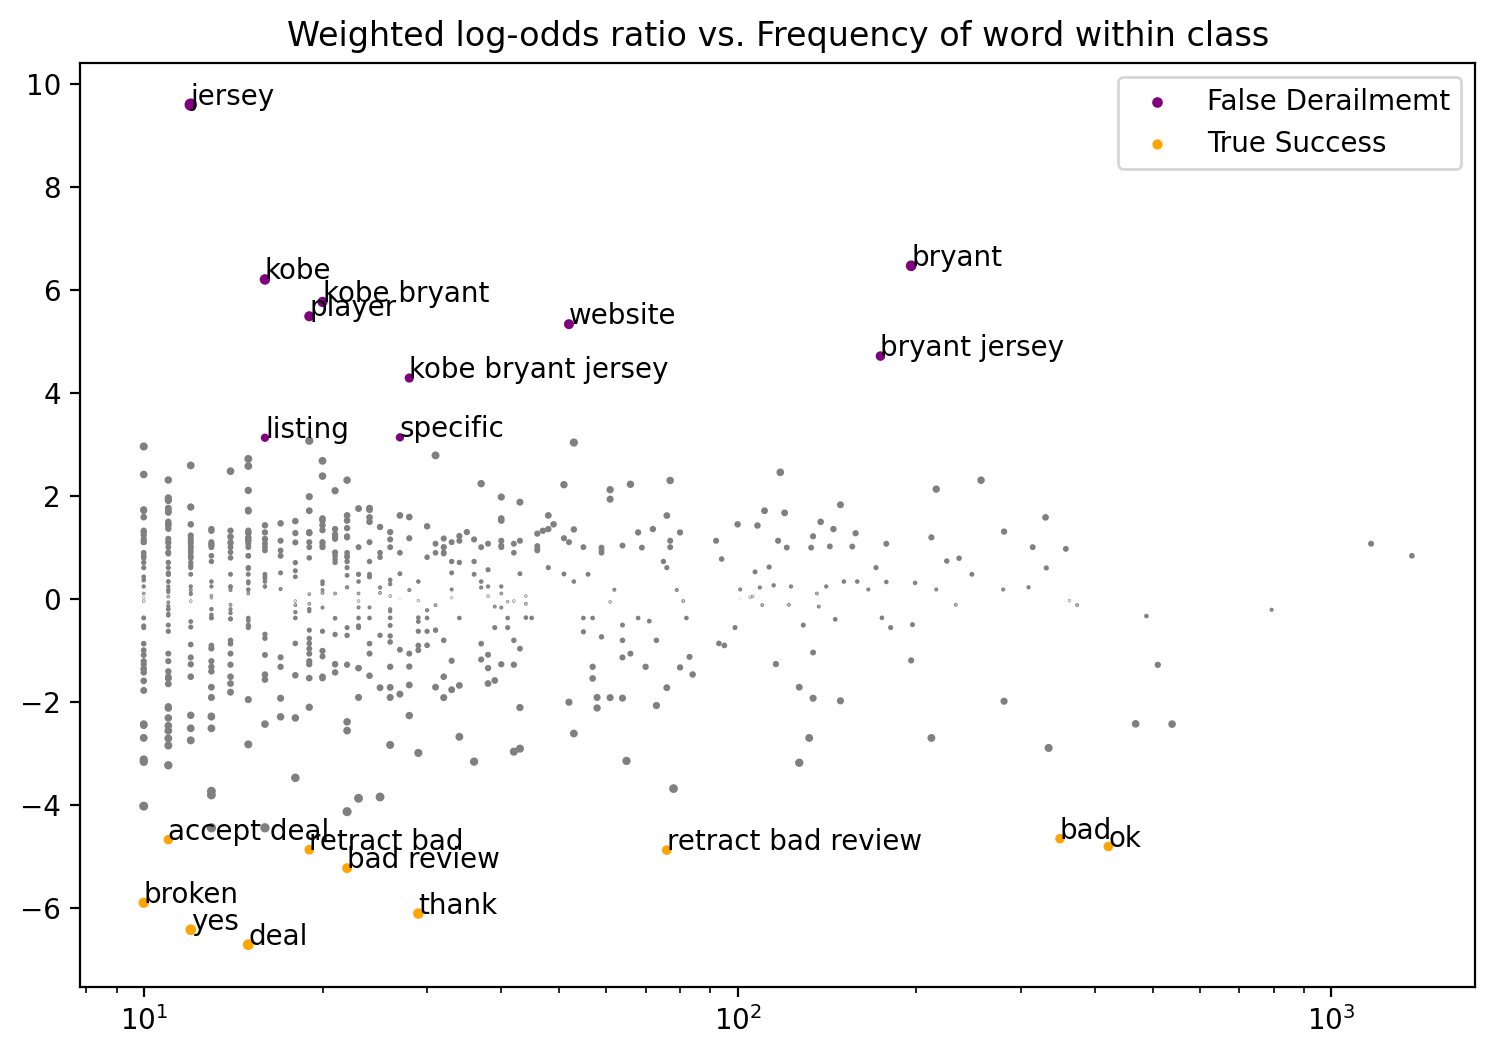

,z-score,class
ngram,,
deal,-6.718907,True Success
yes,-6.428303,True Success
thank,-6.114948,True Success
broken,-5.905448,True Success
bad review,-5.232216,True Success
retract bad review,-4.881626,True Success
retract bad,-4.874775,True Success
ok,-4.812029,True Success
accept deal,-4.678088,True Success


,z-score,class
ngram,,
listing,3.131796,False Derailmemt
specific,3.138968,False Derailmemt
kobe bryant jersey,4.292191,False Derailmemt
bryant jersey,4.718836,False Derailmemt
website,5.338543,False Derailmemt
player,5.492360,False Derailmemt
kobe bryant,5.771620,False Derailmemt
kobe,6.207311,False Derailmemt
bryant,6.473314,False Derailmemt


In [182]:
# display(no_last_downsampled.get_utterances_dataframe()[["text", "meta.pred_score"]])
no_last_downsampled_fr = Corpus(filename='/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/downsampled_run/corpus_kodis_no_last_downsampled')
apply_best_threshold(no_last_downsampled_fr, threshold=0.5597192049026489, selector=convo_selector)

f_model, z_df_utt= analyze_mispredicted_fighting_words(no_last_downsampled_fr, plot=True, key="false_pos_true_neg", custom_vec = False)
display(z_df_utt.head(10)) 
display(z_df_utt.tail(10))

### Fighting Words Analysis Example: False Derailment vs True Sucess for No Last No Submit Agreement Downsampled Model (Conversation Level)

class1_func returned 232 valid corpus components. class2_func returned 117 valid corpus components.
Vocab size is 1999
Comparing language...
ngram zscores computed.


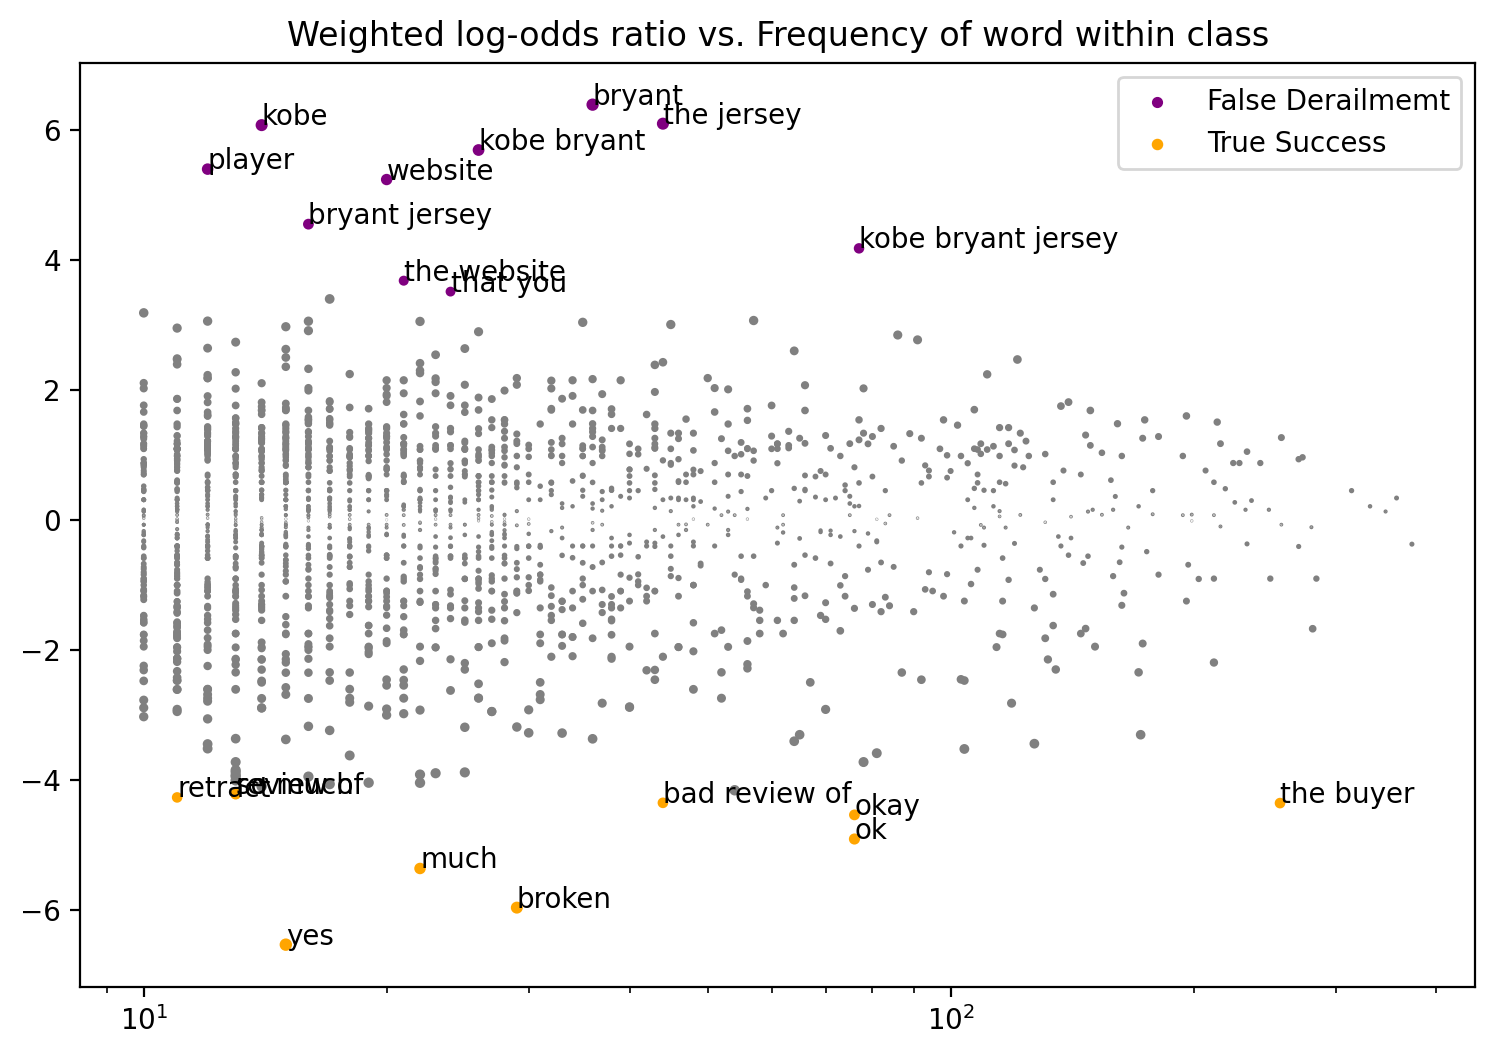

,z-score,class
ngram,,
yes,-6.535231,True Success
broken,-5.965318,True Success
much,-5.362650,True Success
ok,-4.909162,True Success
okay,-4.537755,True Success
the buyer,-4.356455,True Success
bad review of,-4.352271,True Success
retract,-4.268908,True Success
so much,-4.220469,True Success


,z-score,class
ngram,,
that you,3.516404,False Derailmemt
the website,3.684440,False Derailmemt
kobe bryant jersey,4.182163,False Derailmemt
bryant jersey,4.554592,False Derailmemt
website,5.241377,False Derailmemt
player,5.401609,False Derailmemt
kobe bryant,5.695863,False Derailmemt
kobe,6.078845,False Derailmemt
the jersey,6.101230,False Derailmemt


In [181]:

f_model, z_df_conv = analyze_mispredicted_fighting_words_by_conversation(no_last_downsampled_fr, plot=True, key="false_pos_true_neg", custom_vec = False)
display(z_df_conv.head(10)) 
display(z_df_conv.tail(10))

### Fighting Words Analysis Example: False Derailment vs True Derailment for No Last No Submit Agreement Downsampled Model (Utterance Level)

class1_func returned 65 valid corpus components. class2_func returned 232 valid corpus components.
Vocab size is 2013
Comparing language...
ngram zscores computed.


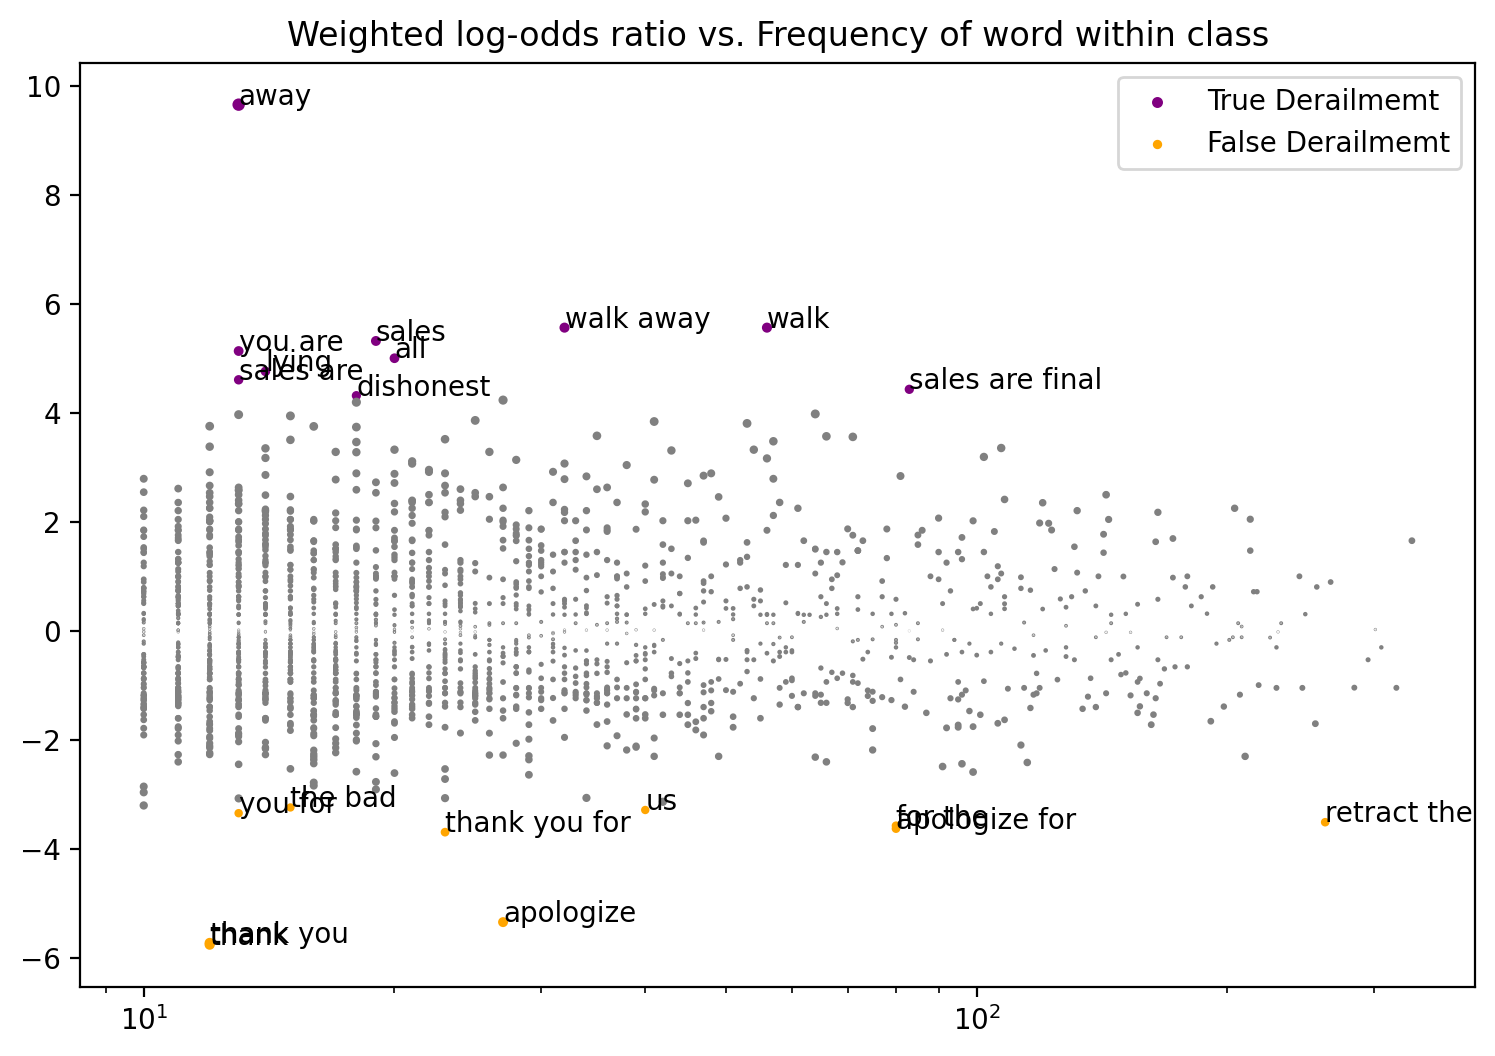

,z-score,class
ngram,,
thank,-5.749773,False Derailmemt
thank you,-5.718247,False Derailmemt
apologize,-5.336655,False Derailmemt
thank you for,-3.687553,False Derailmemt
apologize for,-3.622634,False Derailmemt
for the,-3.569466,False Derailmemt
retract the,-3.504892,False Derailmemt
you for,-3.339534,False Derailmemt
us,-3.280998,False Derailmemt


,z-score,class
ngram,,
dishonest,4.315086,True Derailmemt
sales are final,4.431480,True Derailmemt
sales are,4.605759,True Derailmemt
lying,4.759982,True Derailmemt
all,5.001141,True Derailmemt
you are,5.133342,True Derailmemt
sales,5.317728,True Derailmemt
walk,5.562037,True Derailmemt
walk away,5.562037,True Derailmemt


In [184]:
f_model, z_df_conv = analyze_mispredicted_fighting_words_by_conversation(no_last_downsampled_fr, plot=True, key="true_pos_false_pos", custom_vec = False)
display(z_df_conv.head(10)) 
display(z_df_conv.tail(10))

# Predicition Evolution Overtime

### Ground Model Performance Comparison Across Default, Weighted, Downsampled Variants

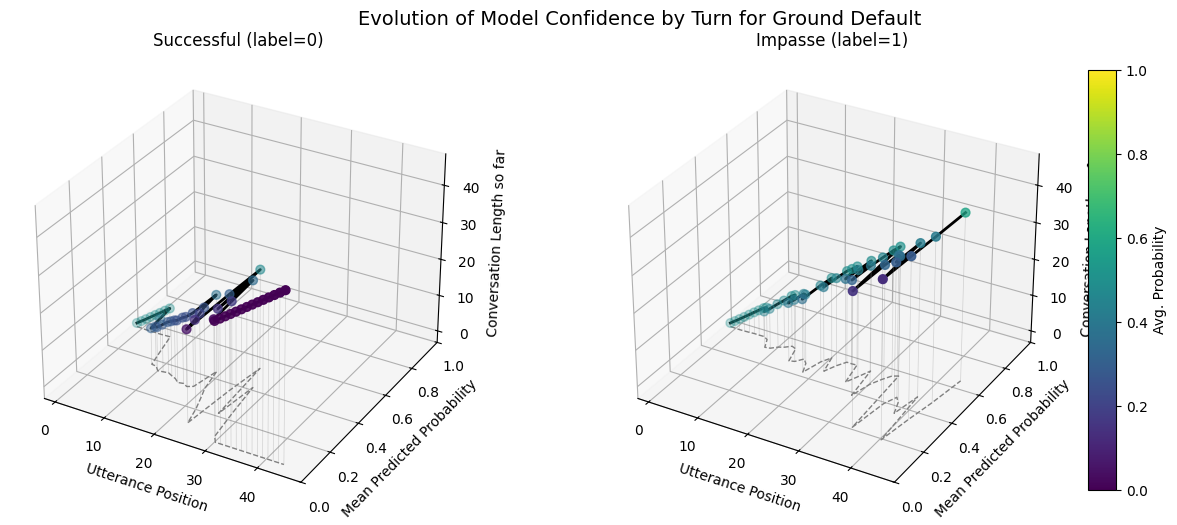

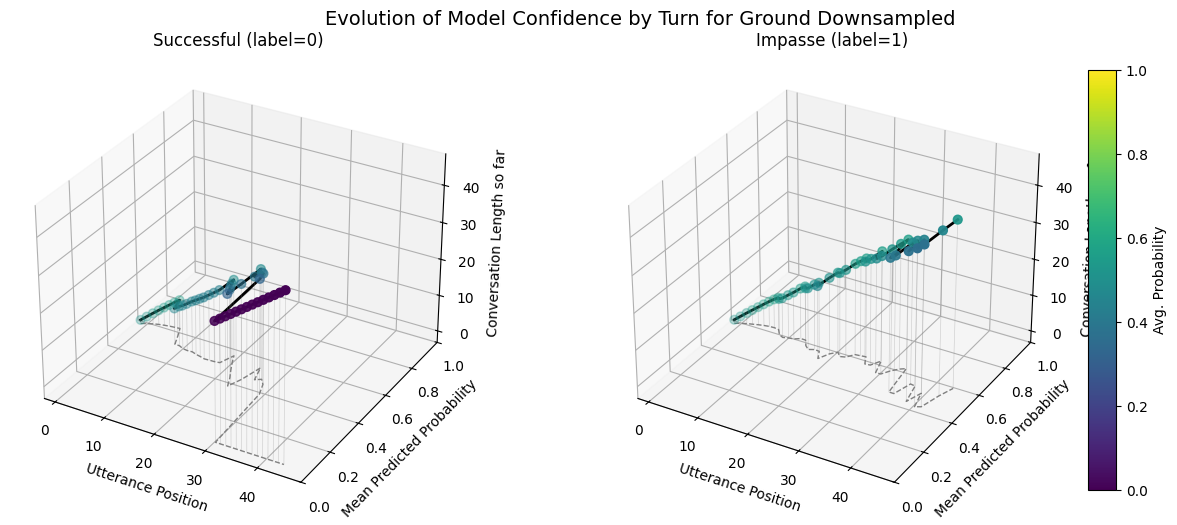

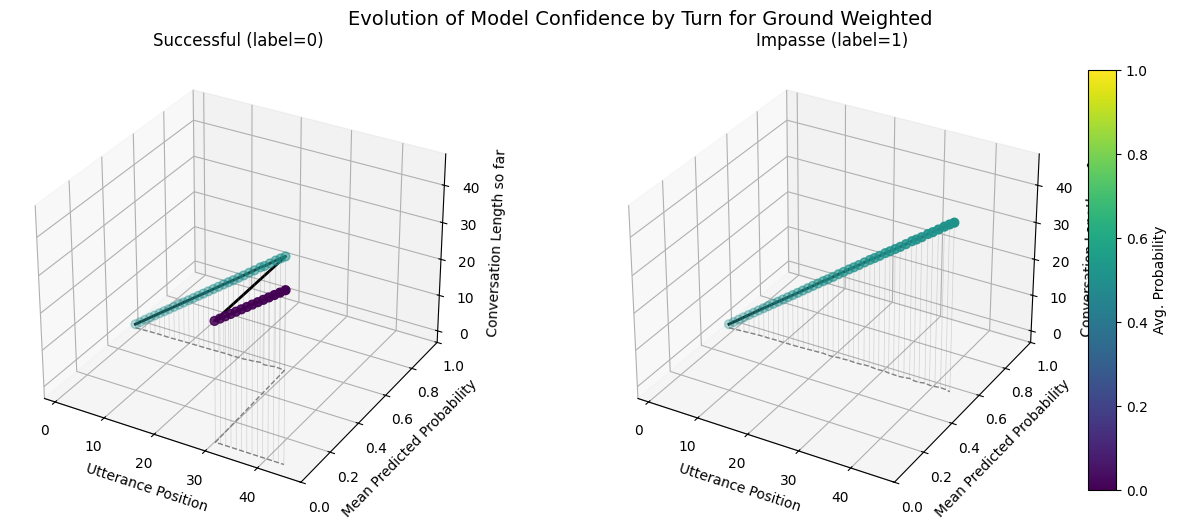

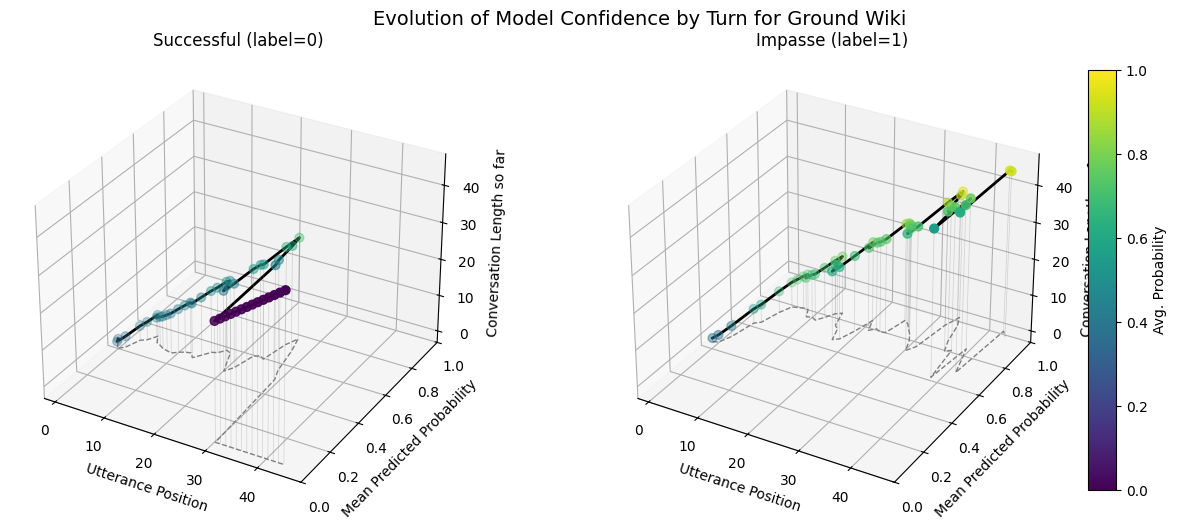

In [148]:
plot_position_score_evolution_by_outcome(no_samp["ground_corpus"], name = "Ground Default")
plot_position_score_evolution_by_outcome(down["ground_corpus"], name = "Ground Downsampled")
plot_position_score_evolution_by_outcome(wt["ground_corpus"], name = "Ground Weighted")
plot_position_score_evolution_by_outcome(wiki["ground_corpus"], name = "Ground Wiki")

### No Last Utt Model Performance Comparison Across Default, Weighted, Downsampled Variants

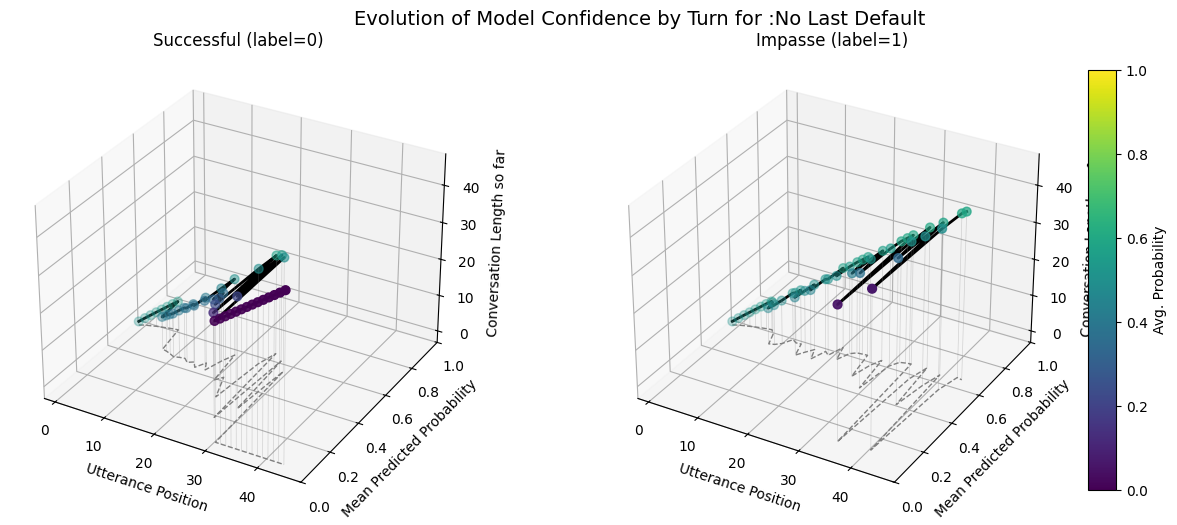

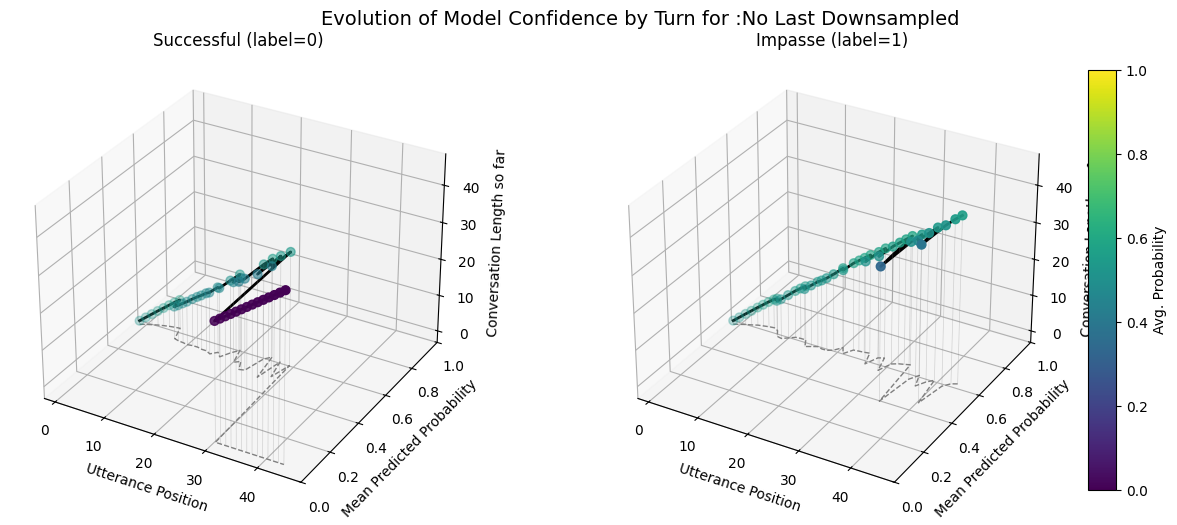

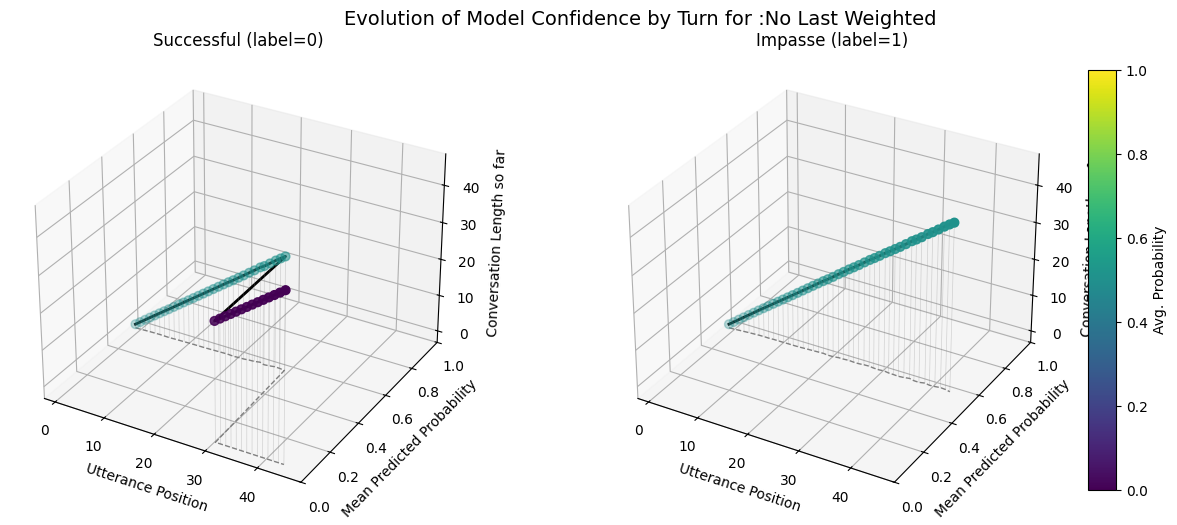

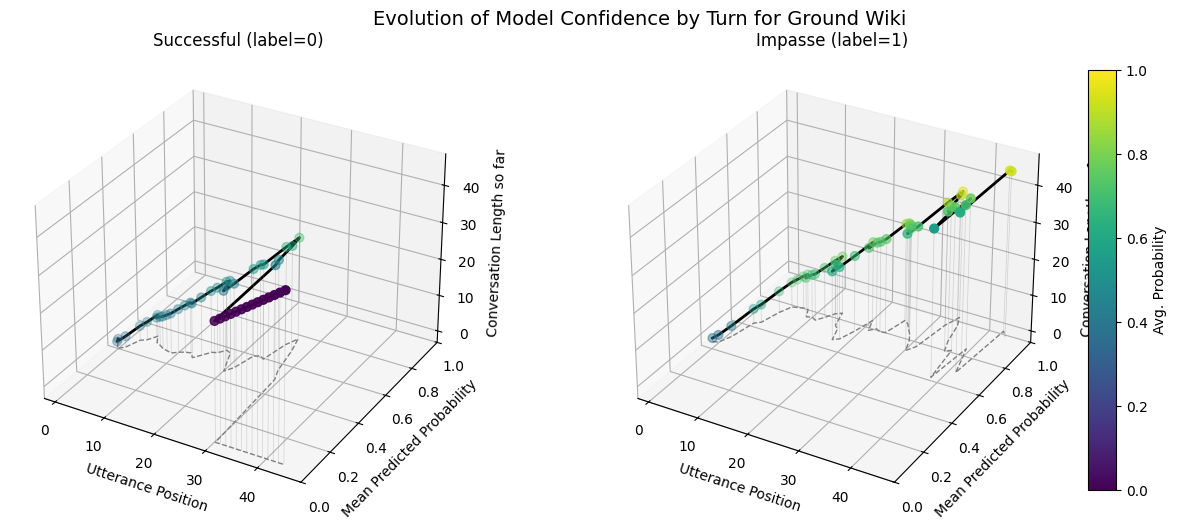

In [149]:
plot_position_score_evolution_by_outcome(no_samp["no_last_corpus"], name = ":No Last Default")
plot_position_score_evolution_by_outcome(down["no_last_corpus"], name = ":No Last Downsampled")
plot_position_score_evolution_by_outcome(wt["no_last_corpus"], name = ":No Last Weighted")
plot_position_score_evolution_by_outcome(wiki["ground_corpus"], name = "Ground Wiki")

### No Last/No Submit Model Performance Comparison Across Default, Weighted, Downsampled Variants

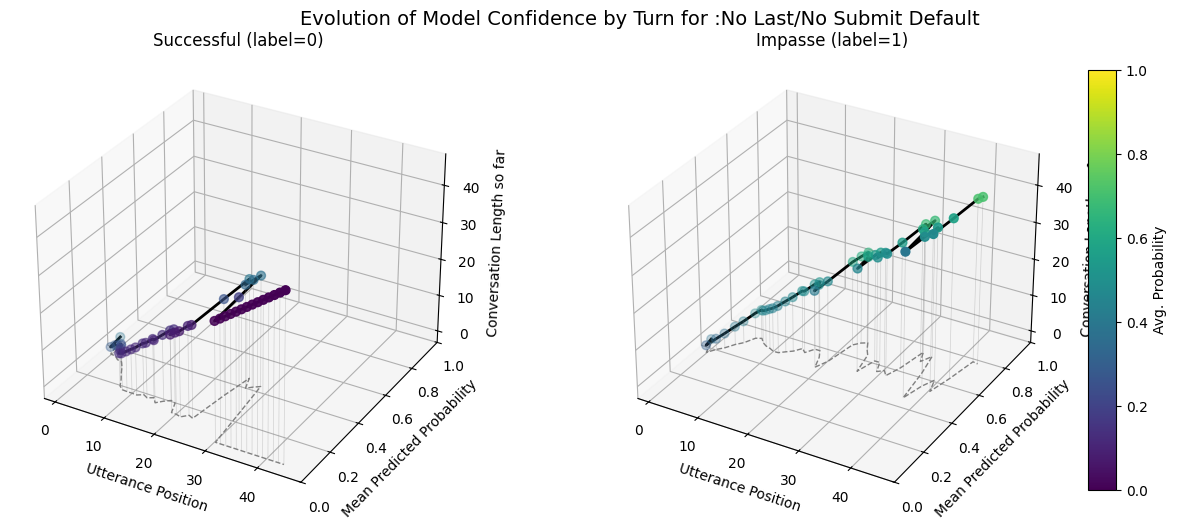

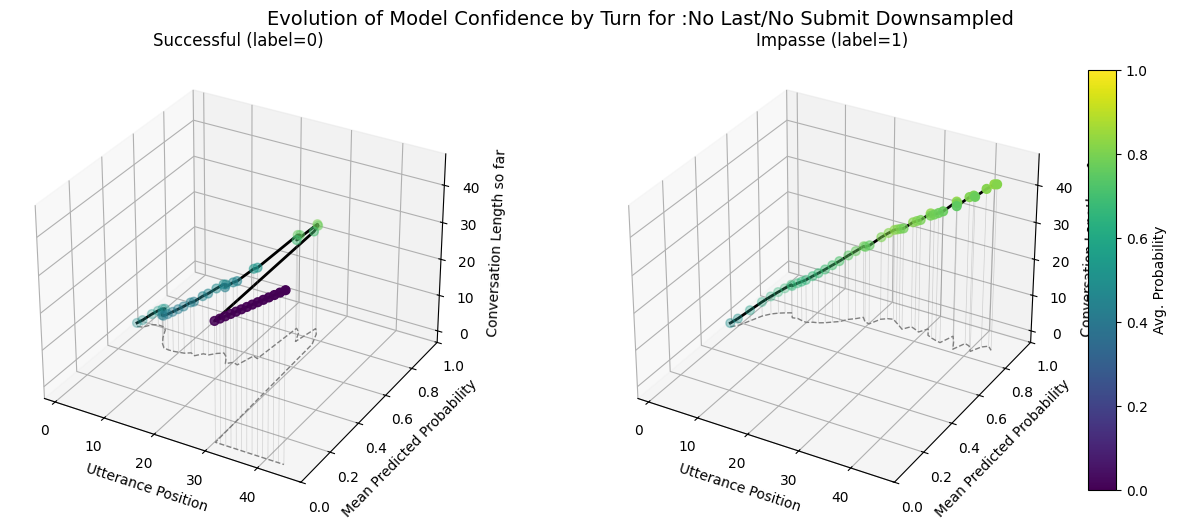

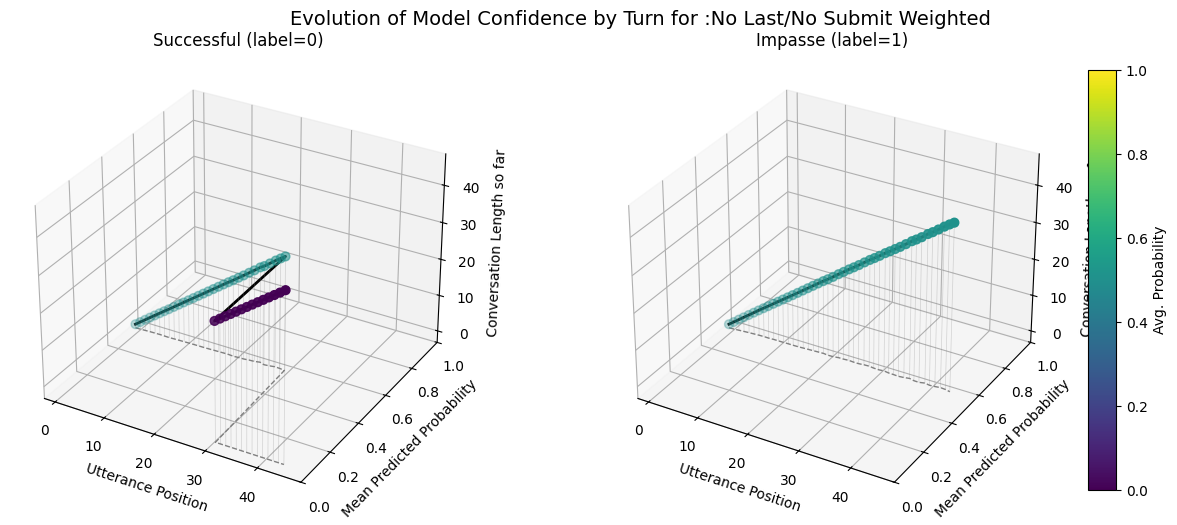

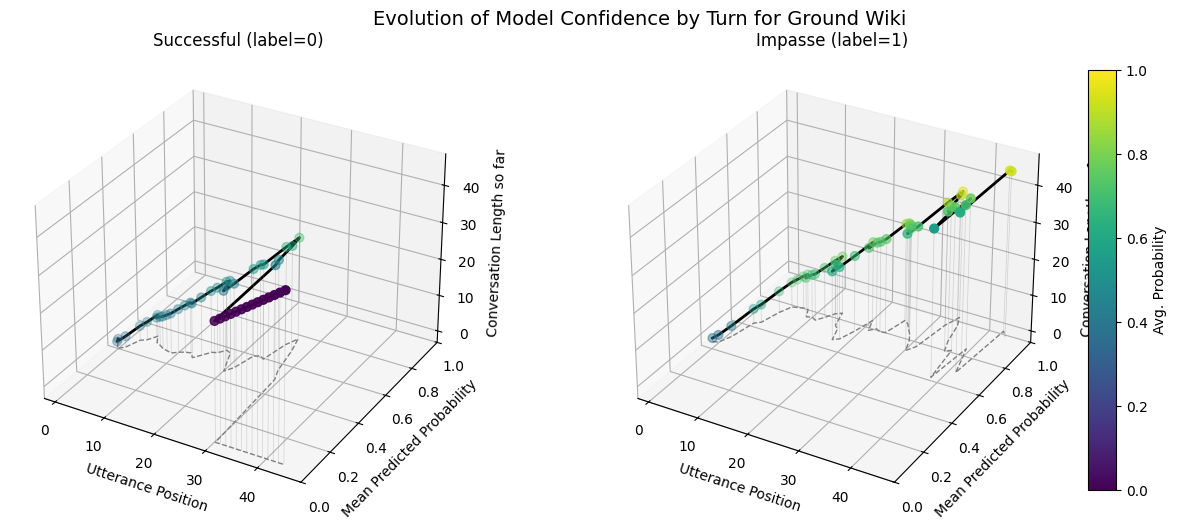

In [150]:
plot_position_score_evolution_by_outcome(no_samp["no_subm_corpus"], name = ":No Last/No Submit Default")
plot_position_score_evolution_by_outcome(down["no_subm_corpus"], name = ":No Last/No Submit Downsampled")
plot_position_score_evolution_by_outcome(wt["no_subm_corpus"], name = ":No Last/No Submit Weighted")
plot_position_score_evolution_by_outcome(wiki["ground_corpus"], name = "Ground Wiki")

# Frustration Correlation

### No Last Downsampled: Correlation with highest predicted score per conversation and avg_frustration frequency 

In [ ]:

0.7579975724220276 
add_avg_frustration_score(no_last_downsampled_fr)
add_max_pred_score_to_conversations(no_last_downsampled_fr)
add_max_pred_score_to_conversations(no_last_downsampled_fr)
#display(no_last_downsampled_fr.get_conversations_dataframe())

The numbr of conversations to perform regression analysis on is 358


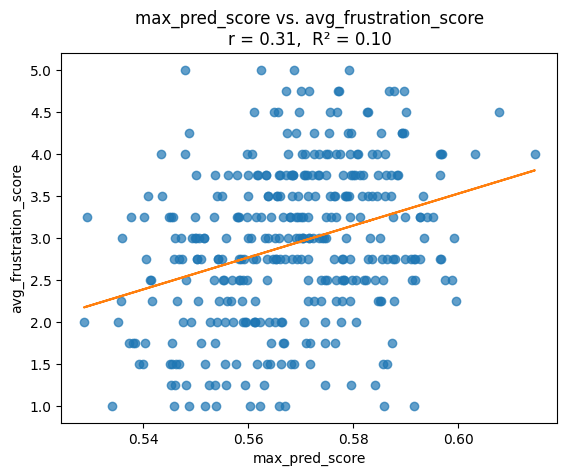

In [171]:
df, corr, r2 = evaluate_prediction_vs_frustration(no_last_downsampled_fr)

### No Last No SubmitDownsampled: Correlation with highest predicted score per conversation and avg_frustration frequency 

In [ ]:
no_last_submit_downsampled = Corpus(filename='/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/downsampled_run/corpus_kodis_no_last_submit_downsampled')
apply_best_threshold(no_last_submit_downsampled, threshold=0.7579975724220276, selector=convo_selector)
add_avg_frustration_score(no_last_submit_downsampled)
add_max_pred_score_to_conversations(no_last_submit_downsampled)
# display(no_last_submit_downsampled.get_conversations_dataframe())

The numbr of conversations to perform regression analysis on is 358


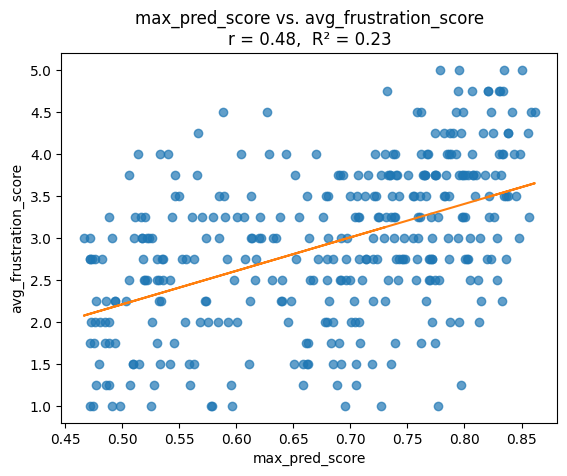

In [176]:
df, corr, r2 = evaluate_prediction_vs_frustration(no_last_submit_downsampled)

### Ground Wiki: Correlation with highest predicted score per conversation and avg_frustration frequency 

In [ ]:
wiki_corp = corpus_kodis_ground_orig
apply_best_threshold(wiki_corp, threshold=0.7579975724220276, selector=convo_selector)
add_avg_frustration_score(wiki_corp)
add_max_pred_score_to_conversations(wiki_corp)

The numbr of conversations to perform regression analysis on is 359


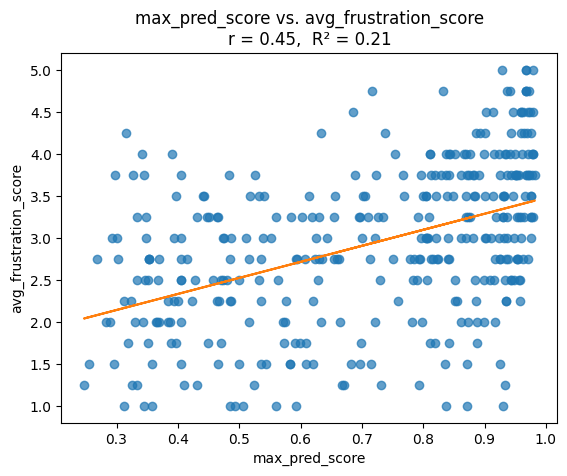

In [179]:
df, corr, r2 = evaluate_prediction_vs_frustration(wiki_corp)

# Utility Functions

### ConvoKit Transformers

### Metric and Plotting Functions

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Callable
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)
from IPython.display import display
from sklearn.calibration import CalibrationDisplay

def find_best_threshold(y_true, y_score):
    """
    Return the threshold that maximizes Youden's J = TPR − FPR.
    """
    fpr, tpr, thresh = roc_curve(y_true, y_score)
    youden = tpr - fpr
    idx    = np.argmax(youden)
    return thresh[idx], tpr[idx], fpr[idx], youden[idx]


def apply_best_threshold(corpus, threshold, prob_key= "pred_score", best_pred_key= "best_prediction",
    best_label_key= "best_forecast", selector: Callable[[Conversation], bool] = lambda convo: True):
    for convo in corpus.iter_conversations(selector):
        any_pos = False
        for utt in convo.iter_utterances():
            score = utt.meta.get(prob_key, 0.0)
            pred  = int(score >= threshold)
            utt.meta[best_pred_key] = pred
            if pred:
                any_pos = True
        convo.meta[best_label_key] = int(any_pos)

def horizon(corpus: Corpus, selector: Callable[[Conversation], bool] = lambda convo: True):
        comments_until_end = {}
        for convo in corpus.iter_conversations(selector):
            if selector(convo) and convo.meta["best_forecast"] == 1:
                for i, utt in enumerate(convo.get_chronological_utterance_list()):
                    prediction = utt.meta["best_prediction"]
                    if prediction is not None and prediction > 0:
                        comments_until_end[convo.id] = (
                            len(convo.get_chronological_utterance_list()) - i
                        )
                        break
        return comments_until_end

"""Taken + modified from forecaster class"""
def summarize(corpus: Corpus, selector: Callable[[Conversation], bool] = lambda convo: True, threshold = None):
        df = corpus.get_conversations_dataframe(selector=selector)

         # counts
        tp = ((df["meta.label"]==1) & (df["meta.best_forecast"]==1)).sum()
        fp = ((df["meta.label"]==0) & (df["meta.best_forecast"]==1)).sum()
        tn = ((df["meta.label"]==0) & (df["meta.best_forecast"]==0)).sum()
        fn = ((df["meta.label"]==1) & (df["meta.best_forecast"]==0)).sum()

        # accuracy is always well‑defined
        acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0

        # precision, recall, fpr guard against zero‐denom
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr       = fp / (fp + tn) if (fp + tn) > 0 else 0.0

        # F1 = 2 * (precision * recall) / (precision + recall)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0


        return {
            "Accuracy":  acc,
            "Precision": precision,
            "Recall":    recall,
            "FPR":       fpr,
            "F1":        f1,
            "Best Threshold": threshold,}
       

def all_confusion_matrices(corpora_info):
    names, corpora, metrics_list, dfs, horizons = zip(*corpora_info)
    merged = dfs[0][['label','score','forecast']].rename(
        columns={'score':f'score_{names[0]}','forecast':f'forecast_{names[0]}'})
    for name, df in zip(names[1:], dfs[1:]):
        merged = merged.join(
            df[['score','forecast']].rename(
                columns={'score':f'score_{name}','forecast':f'forecast_{name}'}
            ), how='inner'
        )

    # 6) confusion matrices
    fig, axes = plt.subplots(1, len(names), figsize=(4*len(names),4))
    if len(names)==1: axes=[axes]
    for ax, name in zip(axes, names):
        ConfusionMatrixDisplay.from_predictions(
            y_true=merged['label'],
            y_pred=merged[f'forecast_{name}'],
            display_labels=["Success","Impasse"],
            ax=ax
        )
        ax.set_title(name)

    plt.tight_layout(); plt.show()

def compare_craft_models(corpora_info, split_key="split", train_tag="train", test_tag="test", best= None):
    """
    corpora_info: list of (name, Corpus, metrics_dict, conv_df, horizon_dict)
    """
    names, corpora, metrics_list, dfs, horizons = zip(*corpora_info)

    # 1) avg lengths
    print("== Avg. Conversation Length ==")
    for name, corpus in zip(names, corpora):
        train_lens = [
            len(conv.get_utterance_ids())
            for conv in corpus.iter_conversations()
            if conv.meta.get(split_key)==train_tag
        ]
        test_lens  = [
            len(conv.get_utterance_ids())
            for conv in corpus.iter_conversations()
            if conv.meta.get(split_key)==test_tag
        ]
        print(f"  {name:20s}  train={np.mean(train_lens):.1f}  test={np.mean(test_lens):.1f}")
    print()

    # 2) metrics table
    print("== Conversation‑level Test Metrics ==")
    metrics_df = pd.DataFrame(metrics_list, index=names)
    display(metrics_df)

    # 3) horizon histograms
    all_vals   = np.concatenate([list(h.values()) for h in horizons])
    global_max = int(all_vals.max()) if all_vals.size else 1
    bins       = np.arange(1, global_max+2)
    fig, axes  = plt.subplots(1, len(names), figsize=(5*len(names),4), sharey=True)
    if len(names)==1: axes=[axes]
    for ax, name, hor in zip(axes, names, horizons):
        vals = np.array(list(hor.values()))
        ax.hist(vals, bins=bins, density=True, edgecolor="k")
        ax.set_title(f"{name}\nForecast Horizon")
        ax.set_xlabel("# comments after first+forecast")
        ax.set_xlim(1, global_max+1)
        if ax is axes[0]:
            ax.set_ylabel("Percent of convos")
        ax.text(.05,.85, f"μ={vals.mean():.1f}\nmed={np.median(vals):.1f}",
                transform=ax.transAxes, va="top", fontsize=9)
    plt.tight_layout()
    plt.show()

    # 4) merge conversation‑level dfs
    merged = dfs[0][['label','score','forecast']].rename(  
        columns={'score':f'score_{names[0]}','forecast':f'forecast_{names[0]}'})
    for name, df in zip(names[1:], dfs[1:]):
        merged = merged.join(
            df[['score','forecast']].rename(
                columns={'score':f'score_{name}','forecast':f'forecast_{name}'}
            ), how='inner'
        )

    # 5) calibration + probability histogram
    fig, (ax_cal, ax_hist) = plt.subplots(1,2, figsize=(12,4))
    for name in names:
        CalibrationDisplay.from_predictions(
            y_true=merged['label'],
            y_prob=merged[f'score_{name}'],
            n_bins=10, name=name, ax=ax_cal
        )
    ax_cal.set_title("Calibration Curves"); ax_cal.grid(True)

    bins_prob = np.linspace(0,1,11)
    for name in names:
        ax_hist.hist(merged[f'score_{name}'], bins=bins_prob,
                     alpha=0.6, label=name, edgecolor='k')
    ax_hist.set_title("Probability Histogram")
    ax_hist.set_xlabel("Predicted probability")
    ax_hist.set_ylabel("Count of convos")
    ax_hist.legend(); ax_hist.grid(True)

    plt.tight_layout(); plt.show()

    # 6) confusion matrices
    fig, axes = plt.subplots(1, len(names), figsize=(4*len(names),4))
    if len(names)==1: axes=[axes]
    for ax, name in zip(axes, names):
        ConfusionMatrixDisplay.from_predictions(
            y_true=merged['label'],
            y_pred=merged[f'forecast_{name}'],
            display_labels=["Success","Impasse"],
            ax=ax
        )
        ax.set_title(name)
    plt.tight_layout(); plt.show()

    # 7) ROC & PR curves + find best thresholds
    thresholds = {}
    metrics = {}
    corpora = {}
    plt.figure(figsize=(12,5))

    # ROC
    plt.subplot(1,2,1)
    for name in names:
        y_true = merged['label']
        y_score= merged[f'score_{name}']
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
        thr, t, f, j = find_best_threshold(y_true, y_score)
        thresholds[name] = thr
        print(f"{name:20s} best thr={thr:.3f}, TPR={t:.3f}, FPR={f:.3f}, J={j:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.title("ROC Curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(True)

    #annotate corpora with best prediction:
    for name, corpus, *_ in corpora_info:
        if name not in thresholds:
            raise KeyError(f"No threshold provided for model {name!r}")
        apply_best_threshold(corpus, thresholds[name],  selector =lambda convo: convo.meta.get("split") == "test")
        # create best metrics
        metrics[name] = summarize(corpus, selector =lambda convo: convo.meta.get("split") == "test", threshold=thresholds[name])
        corpora[name] = corpus


    # PR
    plt.subplot(1,2,2)
    for name in names:
        prec, rec, _ = precision_recall_curve(merged['label'], merged[f'score_{name}'])
        ap = average_precision_score(merged['label'], merged[f'score_{name}'])
        plt.plot(rec, prec, label=f"{name} (AP={ap:.2f})")
    plt.title("Precision–Recall Curves"); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    # 8) summary table
    summary = {
        f"{name}_acc":      (merged['label']==merged[f'forecast_{name}']).mean()
        for name in names
    }
    summary.update({
        f"{name}_avg_prob": merged[f'score_{name}'].mean()
        for name in names
    })
    print("== Summary of Convo Acc & Avg Prob ==")
    display(pd.DataFrame(summary, index=["conversation_level"]))

    return thresholds, metrics, corpora

def best_thersholds(corpora_info, split_key="split", train_tag="train", test_tag="test"):
     # 7) ROC & PR curves + find best thresholds
    thresholds = {}
    metrics = {}
    corpora = {}
    plt.figure(figsize=(12,5))


    for name in names:
        y_true = merged['label']
        y_score= merged[f'score_{name}']
        thr, t, f, j = find_best_threshold(y_true, y_score)
        thresholds[name] = thr


def compare_best_models(thresholds, metrics, corpora, split_key = "split", test_tag = "test"):
    names = list(corpora.keys())
    # 1) metrics table
    print("== Conversation‑level Best Threshold Test Set Metrics ==")
    metrics_df = pd.DataFrame(metrics, index=list(metrics.values())[0].keys()).T
    display(metrics_df)

    # 2) confusion matrices
    fig, axes = plt.subplots(1, len(names), figsize=(4*len(names), 4))
    if len(names)==1: axes=[axes]

    for ax, name in zip(axes, names):
        
        # collect true/test only
        conv_df = corpora[name].get_conversations_dataframe().reset_index()
        test_df = conv_df[conv_df[f"meta.{split_key}"] == test_tag]
        y_true = test_df["meta.label"].astype(int)
        y_pred = test_df["meta.best_forecast"].astype(int)
        ConfusionMatrixDisplay.from_predictions(
            y_true=y_true,
            y_pred=y_pred,
            display_labels=["Success","Impasse"],
            cmap="Blues",
            ax=ax
        )
        ax.set_title(name)
    plt.tight_layout()
    plt.show()

    # 3) forecast‑horizon histograms
    fig, axes = plt.subplots(1, len(names), figsize=(5*len(names), 4), sharey=True)
    if len(names)==1: axes=[axes]

    # compute global max horizon to align bins
    all_horizons = []
    for name in names:
        h = horizon(corpora[name], selector=lambda c: c.meta.get(split_key)==test_tag)
        all_horizons.extend(h.values())
    max_h = int(max(all_horizons)) if all_horizons else 1
    bins = np.arange(1, max_h+2)

    for ax, name in zip(axes, names):
        h = horizon(corpora[name], selector=lambda c: c.meta.get(split_key)==test_tag)
        vals = np.array(list(h.values()))
        ax.hist(vals, bins=bins, density=True, edgecolor="k")
        ax.set_title(f"{name}\nForecast Horizon")
        ax.set_xlabel("# utts after first + forecast")
        ax.set_xlim(1, max_h+1)
        if ax is axes[0]:
            ax.set_ylabel("Percent of convos")
        m, md = vals.mean() if vals.size else 0, np.median(vals) if vals.size else 0
        ax.text(.05, .85, f"μ={m:.1f}\nmed={md:.1f}",
                transform=ax.transAxes, va="top", fontsize=9)
    plt.tight_layout()
    plt.show()



def compare_best_model_confusion(thresholds, metrics, corpora, split_key = "split", test_tag = "test"):
    names = list(corpora.keys())
    # 2) confusion matrices
    fig, axes = plt.subplots(1, len(names), figsize=(4*len(names), 4))
    if len(names)==1: axes=[axes]
    for ax, name in zip(axes, names):
        # collect true/test only
        conv_df = corpora[name].get_conversations_dataframe().reset_index()
        test_df = conv_df[conv_df[f"meta.{split_key}"] == test_tag]
        y_true = test_df["meta.label"].astype(int)
        y_pred = test_df["meta.best_forecast"].astype(int)
        ConfusionMatrixDisplay.from_predictions(
            y_true=y_true,
            y_pred=y_pred,
            display_labels=["Success","Impasse"],
            cmap="Blues",
            ax=ax
        )
        ax.set_title(name)
    plt.tight_layout()
    plt.show()
    plt.tight_layout()
    plt.show()


def compare_best_model_metrics(metrics, corpora, split_key = "split", test_tag = "test"):
    names = list(corpora.keys())
    # 1) metrics table
    print("== Conversation‑level Best Threshold Test Set Metrics ==")
    metrics_df = pd.DataFrame(metrics, index=list(metrics.values())[0].keys()).T
    display(metrics_df)
    plt.show()


import numpy as np
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt

def compare_best_model_convo_histograms(
    groups_of_corpora_info,
    bins_prob=None,
    title_key: int = 0
):
    """
    groups_of_corpora_info: list of lists of corpora_info tuples
    bins_prob: optional bin edges for the histograms
    title_key: 0 or 1, picks one of two title‐sets
    """
    # pick the right set of group names
    if title_key == 0:
        titles = ["Default", "Downsampled", "Weighted", "Wiki"]
    else:
        titles = ["Ground", "No Last", "No Subm", "Wiki"]
    
    n_groups = len(groups_of_corpora_info)
    if bins_prob is None:
        bins_prob = np.linspace(0, 1, 11)

    fig, axes = plt.subplots(1, n_groups, figsize=(6 * n_groups, 4), sharey=True)
    if n_groups == 1:
        axes = [axes]

    for ax, corpora_info, group_title in zip(axes, groups_of_corpora_info, titles):
        # 1) unpack & merge
        names, _, _, dfs, _ = zip(*corpora_info)
        merged = dfs[0][['label', 'score', 'forecast']].rename(
            columns={'score': f'score_{names[0]}',
                     'forecast': f'forecast_{names[0]}'})
        for name, df in zip(names[1:], dfs[1:]):
            merged = merged.join(
                df[['score', 'forecast']].rename(
                    columns={'score': f'score_{name}',
                             'forecast': f'forecast_{name}'}),
                how='inner'
            )

        # 2) plot histograms
        for name in names:
            ax.hist(
                merged[f'score_{name}'],
                bins=bins_prob,
                density=False,    # raw counts
                alpha=0.6,
                label=name,
                edgecolor='k'
            )

        # 3) compute mean & variance for each model
        stats_lines = []
        for name in names:
            arr = merged[f'score_{name}'].to_numpy()
            mu  = arr.mean()
            var = arr.var()
            stats_lines.append(f"{name}: μ={mu:.2f}, σ²={var:.3f}")
        subtitle = "\n".join(stats_lines)

        # 4) format subplot
        ax.set_title(f"{group_title}\n{subtitle}", fontsize=10)
        ax.set_xlabel("Predicted probability")
        if ax is axes[0]:
            ax.set_ylabel("Count of convos")
        ax.grid(True)
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()


### Conversation Utilities

In [155]:
def print_conversation(corpus, convo_id):
    """
    Pretty–print the dialogue for a single conversation.

    Args:
        corpus:    a ConvoKit Corpus
        convo_id:  the ID of the conversation you want to print
    """
    # grab the utterance DataFrame for that convo
    df = corpus.get_conversation(convo_id).get_utterances_dataframe()
    
    # ensure it's sorted by timestamp (or by its original index order)
    if "timestamp" in df.columns:
        df = df.sort_values("timestamp")
    
    # now print each turn
    for _, row in df.iterrows():
        speaker = row.get("speaker", "Unknown")
        text    = row.get("text", "")
        print(f"{speaker}: {text}")


def add_avg_frustration_score(corpus):
    filepath = "/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/preprocessed_dyads.csv"
    final_data = DataPreprocesser(filepath)
    df= final_data.getDataframe()
    df['avg_frustration_score'] = df[['b_Tact_4', 'b_Tact_9', 's_Tact_4', 's_Tact_9']].apply(
    lambda row: row.mean() if row.notnull().all() else None,
    axis=1
    )
    non_missing = df.dropna(subset=['avg_frustration_score'])
    # Build a mapping from conversation ID to score, only for non-missing scores
    score_map = {
        f"utt0_con{idx}": score
        for idx, score in non_missing['avg_frustration_score'].dropna().items()
    }

    for convo in corpus.iter_conversations():
        # Assign the score if present, else None
        convo.meta['avg_frustration_score'] = score_map.get(convo.id, None)

    return corpus

def add_max_pred_score_to_conversations(corpus, utt_score_key='pred_score', conv_meta_key='max_pred_score'):
    for convo in corpus.iter_conversations():
        # collect all non-null scores
        scores = [
            utt.meta.get(utt_score_key)
            for utt in convo.iter_utterances()
            if utt.meta.get(utt_score_key) is not None
        ]
        # set the max (or None if there were no scores)
        convo.meta[conv_meta_key] = max(scores) if scores else None
    return corpus


### Fighting Words

In [112]:
from convokit.fighting_words.fightingWords import FightingWords
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from typing import Callable
import pandas as pd
from convokit import TextCleaner
from cleantext import clean

import re

def strip_agreement(text: str) -> str:

    patterns = [r"Submitted agreement:", r"\brefund, buyer\b", r"\breview, seller\b"]
    if not any(re.search(pat, text, flags=re.IGNORECASE) for pat in patterns):
        return text
    text = re.sub(
        r"Submitted agreement:.*?\.(\s|$)",
        "",
        text,
        flags=re.IGNORECASE,
    )
    # 2) Remove any leftover 'refund, buyer' or 'review, seller'
    text = re.sub(r"\brefund, buyer\b", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\breview, seller\b", "", text, flags=re.IGNORECASE)
    # 3) Collapse multiple spaces down to one, then strip edges
    return re.sub(r"\s{2,}", " ", text).strip()


def analyze_mispredicted_fighting_words(
    corpus,
    split_key: str      = "split",
    test_tag: str       = "test",
    best_pred_key: str  = "best_forecast",
    label_key: str      = "label",
    prob_key: str       = "pred_score",
    threshold: float    = None,
    custom_vec          = True,
    plot: bool          = True,
    ngram_range=(1,3),
    min_df=10,
    max_df=0.5,
    max_features=15000,
    prior=0.1,
    key: str            = "false_pos_neg"
):
    """
    Identify “fighting words” that distinguish mis‐predicted success vs mis‐predicted impasse
    at the utterance level, optionally filtered by a probability threshold.
    """
    # Define text preprocessor
    def preprocess(text: str) -> str:
        s = strip_agreement(text)
        return FightingWords.clean_text(s)

    # Define misprediction types
    def is_pos(u):
        return True if threshold is None else u.meta.get(prob_key, 0.0) >= threshold
    def is_neg(u):
        return True if threshold is None else u.meta.get(prob_key, 0.0) < threshold

    def false_pos(utt):
        c = utt.get_conversation().meta
        return c.get(split_key)==test_tag and c.get(best_pred_key)==1 and c.get(label_key)==0 and is_pos(utt)
    def false_neg(utt):
        c = utt.get_conversation().meta
        return c.get(split_key)==test_tag and c.get(best_pred_key)==0 and c.get(label_key)==1 and is_neg(utt)
    def true_pos(utt):
        c = utt.get_conversation().meta
        return c.get(split_key)==test_tag and c.get(best_pred_key)==1 and c.get(label_key)==1 and is_pos(utt)
    def true_neg(utt):
        c = utt.get_conversation().meta
        return c.get(split_key)==test_tag and c.get(best_pred_key)==0 and c.get(label_key)==0 and is_neg(utt)


    # Map key to class functions and labels
    if key == "false_pos_false_neg":
        class1_func, class2_func = false_pos, false_neg
        class1_label, class2_label = "False Derailmemt", "False Success"
    elif key == "true_pos_true_neg":
        class1_func, class2_func = true_pos, true_neg
        class1_label, class2_label = "True Derailmemt", "True Success"
    elif key == "true_pos_false_pos":
        class1_func, class2_func = true_pos, false_pos
        class1_label, class2_label = "True Derailmemt", "False Derailmemt"
    elif key == "false_pos_true_neg":
        class1_func, class2_func = false_pos, true_neg
        class1_label, class2_label ="False Derailmemt", "True Success"
    else:
        raise ValueError(f"Unknown key {key!r}")

    if custom_vec:
        """ Build over entire corpus """
        cv_custom = CountVectorizer(
            preprocessor=preprocess,
            stop_words='english',
            min_df=min_df,
            max_df=max_df,
            ngram_range=ngram_range,
            max_features=max_features
        )
        all_texts = [u.text for u in corpus.iter_utterances()]
        cv_custom.fit(all_texts)
        prior_counts = cv_custom.transform(all_texts).toarray().sum(axis=0)
        cv_locked = CountVectorizer(vocabulary=cv_custom.vocabulary_, preprocessor=preprocess)
        # Instantiate and fit FightingWords
        fw = FightingWords(
            text_func=lambda utt: preprocess(utt.text),
            cv=cv_locked,
            prior=prior_counts
        )
    else:
        """ Build over the utterances in the selected classes """
        cv= CountVectorizer(
            min_df=min_df,
            max_df=max_df,
            stop_words= 'english',
            ngram_range=ngram_range,
            max_features=max_features,
         )
        fw = FightingWords(
            text_func=lambda utt: preprocess(utt.text),
            obj_type="utterance",
            ngram_range=ngram_range,
            cv= cv,
            prior= prior
        )
    

    fw.fit(corpus, class1_func=class1_func, class2_func=class2_func,
            selector=lambda utt: utt.get_conversation().meta.get(split_key)==test_tag)

    # Extract z‐scores with dynamic labels
    zdf = fw.get_ngram_zscores(class1_name=class1_label, class2_name=class2_label)

    # Plot if needed
    if plot:
        cfg = {"annot_method":"top_k", "top_k":10}
        fw.plot_fighting_words(
            max_label_size=12,
            class1_name=class1_label,
            class2_name=class2_label,
            config=cfg
        )

    return fw, zdf


### Fighting Words By conversation

In [116]:

from convokit.fighting_words.fightingWords import FightingWords
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from typing import Callable, Tuple
import pandas as pd
from convokit import TextCleaner
from cleantext import clean
import re


def strip_agreement(text: str) -> str:
    patterns = [r"Submitted agreement:", r"\brefund, buyer\b", r"\breview, seller\b"]
    if not any(re.search(pat, text, flags=re.IGNORECASE) for pat in patterns):
        return text
    text = re.sub(r"Submitted agreement:.*?\.(\s|$)", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\brefund, buyer\b", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\breview, seller\b", "", text, flags=re.IGNORECASE)
    return re.sub(r"\s{2,}", " ", text).strip()


def analyze_mispredicted_fighting_words_by_conversation(
    corpus,
    split_key: str      = "split",
    test_tag: str       = "test",
    best_pred_key: str  = "best_forecast",
    label_key: str      = "label",
    prob_key: str       = "pred_score",
    threshold: float    = None,
    custom_vec: bool    = True,
    plot: bool          = True,
    ngram_range: Tuple[int,int] = (1,3),
    min_df: int         = 10,
    max_df: float       = 0.5,
    max_features: int   = 15000,
    prior: float        = 0.1,
    key: str            = "false_pos_neg"
) -> Tuple[FightingWords, pd.DataFrame]:
    """
    Variation of FightingWords at the **conversation** level.
    Compares two classes of conversations (e.g. mispredictions) rather than utterances.
    """
    # Preprocessor for raw text
    def preprocess(text: str) -> str:
        return FightingWords.clean_text(strip_agreement(text))

    # Helpers for conversation-level threshold
    def is_pos_conv(conv):
        return True if threshold is None else conv.meta.get(prob_key, 0.0) >= threshold
    def is_neg_conv(conv):
        return True if threshold is None else conv.meta.get(prob_key, 0.0) < threshold

    # Class definitions on conversation.meta
    def false_pos(convo):
        m = convo.meta
        return (m.get(split_key)==test_tag and m.get(best_pred_key)==1
                and m.get(label_key)==0 and is_pos_conv(convo))
    def false_neg(convo):
        m = convo.meta
        return (m.get(split_key)==test_tag and m.get(best_pred_key)==0
                and m.get(label_key)==1 and is_neg_conv(convo))
    def true_pos(convo):
        m = convo.meta
        return (m.get(split_key)==test_tag and m.get(best_pred_key)==1
                and m.get(label_key)==1 and is_pos_conv(convo))
    def true_neg(convo):
        m = convo.meta
        return (m.get(split_key)==test_tag and m.get(best_pred_key)==0
                and m.get(label_key)==0 and is_neg_conv(convo))

    # Map key to class functions and labels
    if key == "false_pos_false_neg":
        class1_func, class2_func = false_pos, false_neg
        class1_label, class2_label = "False Derailmemt", "False Success"
    elif key == "true_pos_true_neg":
        class1_func, class2_func = true_pos, true_neg
        class1_label, class2_label = "True Derailmemt", "True Success"
    elif key == "true_pos_false_pos":
        class1_func, class2_func = true_pos, false_pos
        class1_label, class2_label = "True Derailmemt", "False Derailmemt"
    elif key == "false_pos_true_neg":
        class1_func, class2_func = false_pos, true_neg
        class1_label, class2_label ="False Derailmemt", "True Success"
    else:
        raise ValueError(f"Unknown key {key!r}")

    # Build vectorizer over full set of conversation texts
    if custom_vec:
        cv_full = CountVectorizer(
            preprocessor=preprocess,
            stop_words='english',
            min_df=min_df,
            max_df=max_df,
            ngram_range=ngram_range,
            max_features=max_features
        )
        # Gather all conversation-level texts
        all_texts = [preprocess(" ".join(utt.text for utt in convo.iter_utterances()))
                     for convo in corpus.iter_objs("conversation")]
        cv_full.fit(all_texts)
        prior_counts = cv_full.transform(all_texts).toarray().sum(axis=0)
        cv_locked = CountVectorizer(vocabulary=cv_full.vocabulary_, preprocessor=preprocess)
        fw = FightingWords(
            obj_type="conversation",
            text_func=lambda convo: preprocess(" ".join(utt.text for utt in convo.iter_utterances())),
            cv=cv_locked,
            prior=prior_counts
        )
    else:
        # Default uniform prior over subset vocabulary
        cv_sub = CountVectorizer(
            preprocessor=preprocess,
            min_df=min_df,
            max_df=max_df,
            ngram_range=ngram_range,
            max_features=max_features
        )
        fw = FightingWords(
            obj_type="conversation",
            text_func=lambda convo: preprocess(" ".join(utt.text for utt in convo.iter_utterances())),
            cv=cv_sub,
            prior=prior
        )

    # Fit on selected conversations
    fw.fit(
        corpus,
        class1_func=class1_func,
        class2_func=class2_func,
        selector=lambda convo: convo.meta.get(split_key)==test_tag
    )

    # Extract z-scores DataFrame
    zdf = fw.get_ngram_zscores(class1_name=class1_label, class2_name=class2_label)

    # Optionally plot
    if plot:
        cfg = {"annot_method": "top_k", "top_k": 10}
        fw.plot_fighting_words(
            max_label_size=12,
            class1_name=class1_label,
            class2_name=class2_label,
            config=cfg
        )

    return fw, zdf



### Forecasting Trends

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict


def plot_position_score_evolution_by_outcome(
    corpus, split_key="split", test_tag="test",
    prob_key="pred_score", name=None
):
    pos_scores = {0: defaultdict(list), 1: defaultdict(list)}
    for convo in corpus.iter_conversations():
        if convo.meta.get(split_key) != test_tag:
            continue
        lbl = convo.meta.get("label")
        for p, utt in enumerate(convo.iter_utterances(), start=1):
            score = utt.meta.get(prob_key)
            if score is not None:
                pos_scores[lbl][p].append(score)

    overall_max_pos = max(
        max(d.keys()) for d in pos_scores.values() if d
    ) if any(pos_scores.values()) else 0

    fig = plt.figure(figsize=(14, 6))
    fig.subplots_adjust(left=0.05, right=0.80, wspace=0.3)

    for ix, lbl in enumerate((0, 1), start=1):
        ax = fig.add_subplot(1, 2, ix, projection='3d')

        X = np.arange(1, overall_max_pos + 1)
        Y = [
            np.mean(pos_scores[lbl].get(p, [])) if pos_scores[lbl].get(p)
            else 0.0
            for p in X
        ]
        Z = X

        # force colormap and scatter scale to 0→1
        sc = ax.scatter(
            X, Y, Z,
            c=Y, cmap='viridis',
            vmin=0, vmax=1,
            s=40
        )
        ax.plot(X, Y, Z, color='black', lw=2)
        ax.plot(X, Y, zs=0, zdir='z', color='gray', ls='--', lw=1)
        for xi, yi, zi in zip(X, Y, Z):
            ax.plot([xi, xi], [yi, yi], [0, zi],
                    color='gray', alpha=0.3, lw=0.5)

        ax.set_xlabel("Utterance Position")
        ax.set_ylabel("Mean Predicted Probability")
        ax.set_zlabel("Conversation Length so far")
        ax.set_ylim(0, 1)                      # <— lock the probability axis
        title_lbl = "Successful" if lbl == 0 else "Impasse"
        ax.set_title(f"{title_lbl} (label={lbl})")

    # add colorbar to its own axes on the far right
    cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    cb = fig.colorbar(sc, cax=cbar_ax)
    cb.set_label("Avg. Probability")

    if name:
        fig.suptitle(
            f"Evolution of Model Confidence by Turn for {name}",
            y=0.95, fontsize=14
        )

    plt.show()

### Wiki Ground Functions

In [5]:
filepath = "/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/preprocessed_dyads.csv"
filepath_no_last = '/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/convos_exclude_last_utt.csv'
filepath_no_submit_last = '/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/convos_exclude_submit_and_last.csv'

results_filepath_no_samp = Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/nosampling/")
results_filepath_no_samp_weighted = Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/nosampling_weighted/")
results_filepath_downsampled = Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/downsampled/")

def add_convo_labels(corpus, final_data):
    for idx, row in final_data.getDataframe().iterrows():
        convo_id = f"utt0_con{idx}"  # generate conversation_id format from index
        label = row["dispute_outcome"]  # update if your label column is named differently
        if convo_id in corpus.conversations:
            corpus.get_conversation(convo_id).meta["label"] = label

def corpus_train_test_split(corpus):

    # Set random seed for reproducibility
    random.seed(42)

    # 1. Get all conversation IDs
    all_convo_ids = list(corpus.get_conversation_ids())

    # 2. Shuffle the conversation IDs
    random.shuffle(all_convo_ids)

    # 3. Define proportions
    n_total = len(all_convo_ids)
    n_train = int(0.7 * n_total)
    n_val = int(0.1 * n_total)
    n_test = n_total - n_train - n_val  # ensures 100% total

    # 4. Split into train/val/test
    train_convos = all_convo_ids[:n_train]
    val_convos = all_convo_ids[n_train:n_train+n_val]
    test_convos = all_convo_ids[n_train+n_val:]


    # 5. Mark conversations with a split tag
    for convo_id in train_convos:
        corpus.get_conversation(convo_id).meta["split"] = "train"
    for convo_id in val_convos:
        corpus.get_conversation(convo_id).meta["split"] = "val"
    for convo_id in test_convos:
        corpus.get_conversation(convo_id).meta["split"] = "test"

def fit_selector(context_tuple, split):
    """
    Select only contexts in the given split, at the end of the conversation,
    and skip any utterance that’s been tagged exclude=True.
    """
    # only keep the desired split
    matches_split = (
        context_tuple.current_utterance
            .get_conversation()
            .meta["split"]
        == split
    )
    # only keep the final context in each convo
    is_end = (len(context_tuple.future_context) == 0)
    # # skip if the current utterance was marked exclude=True
    # not_excluded = not context_tuple.current_utterance.meta.get("exclude", False)

    return matches_split and is_end 

def transform_selector(context_tuple):
    """
    For transform we only need to check that the conversation is in the test split
    """
    return (context_tuple.current_utterance.get_conversation().meta["split"] == "test")


# selector for summarize: takes a Conversation
def convo_selector(convo: Conversation):
    return convo.meta.get("split") == "test"




""" CRAFT MODEL INSTANCES """
model_wiki = CRAFTModel(
    initial_weights= "craft-wiki-finetuned",  # or "craft-wiki-finetuned"
    torch_device="cuda" if torch.cuda.is_available() else "cpu"
)


""" FORECASTER MODEL INSTANCE """
forecaster_kodis_wiki = Forecaster(
    forecaster_model= model_wiki,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)


### Frustration Correlation

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def evaluate_prediction_vs_frustration(corpus,
                                       split_key: str = "split",
                                       test_tag: str = "test",
                                       pred_meta_key: str = "max_pred_score",
                                       frust_meta_key: str = "avg_frustration_score"):

    records = []
    for convo in corpus.iter_conversations():
        # only test‑split
        if convo.meta.get(split_key) != test_tag:
            continue

        pred_score = convo.meta.get(pred_meta_key)
        frust     = convo.meta.get(frust_meta_key)

        if pred_score is None or frust is None:
            continue

        records.append({
            pred_meta_key: pred_score,
            frust_meta_key: frust
        })

    print(f"The numbr of conversations to perform regression analysis on is {len(records)}")

    df = pd.DataFrame(records)
    if df.empty:
        raise ValueError("No test conversations with both scores present.")

    # correlation
    corr = df[pred_meta_key].corr(df[frust_meta_key])

    # linear regression
    X = df[[pred_meta_key]].values
    y = df[frust_meta_key].values
    lr = LinearRegression().fit(X, y)
    r2 = lr.score(X, y)

    # plot
    plt.figure()
    plt.scatter(df[pred_meta_key], df[frust_meta_key], alpha=0.7)
    plt.plot(df[pred_meta_key], lr.predict(X), color="C1")
    plt.xlabel(pred_meta_key)
    plt.ylabel(frust_meta_key)
    plt.title(f"{pred_meta_key} vs. {frust_meta_key}\n"
              f"r = {corr:.2f},  R² = {r2:.2f}")
    plt.show()

    return df, corr, r2


Row Index not in columns


/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'


Row Index not in columns


/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'


Row Index not in columns


/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'
27498it [00:01, 22699.92it/s]
25391it [00:00, 70088.95it/s]
23117it [00:00, 28601.33it/s]


Processed 5524 context tuples for model evaluation
Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!
Iteration: 1; Percent complete: 1.1%
Iteration: 2; Percent complete: 2.3%
Iteration: 3; Percent complete: 3.4%
Iteration: 4; Percent complete: 4.6%
Iteration: 5; Percent complete: 5.7%
Iteration: 6; Percent complete: 6.9%
Iteration: 7; Percent complete: 8.0%
Iteration: 8; Percent complete: 9.2%
Iteration: 9; Percent complete: 10.3%
Iteration: 10; Percent complete: 11.5%
Iteration: 11; Percent complete: 12.6%
Iteration: 12; Percent complete: 13.8%
Iteration: 13; Percent complete: 14.9%
Iteration: 14; Percent complete: 16.1%
Iteration: 15; Percent complete: 17.2%
Iteration: 16; Percent complete: 18.4%
Iteration: 17; Percent complete: 19.5%
Iteration: 18; Percent complete: 20.7%
Iteration: 19; Percent complete: 21.8%
Iteration: 20; Percent complete: 23.0%
Iteration: 21; Percent complete: 24.1%
Iteration: 22; Percent complete: 25.3%
Iter

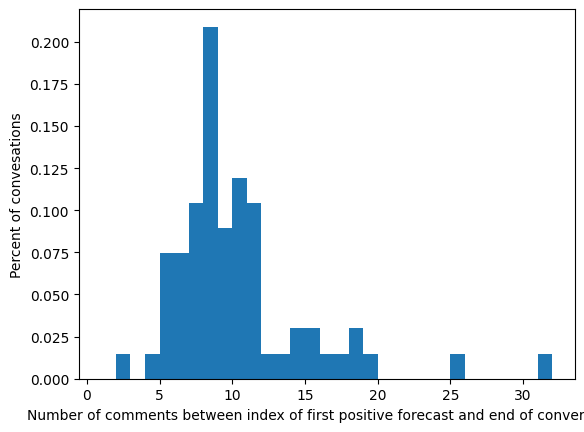

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 10.191176470588236, Median = 9.0


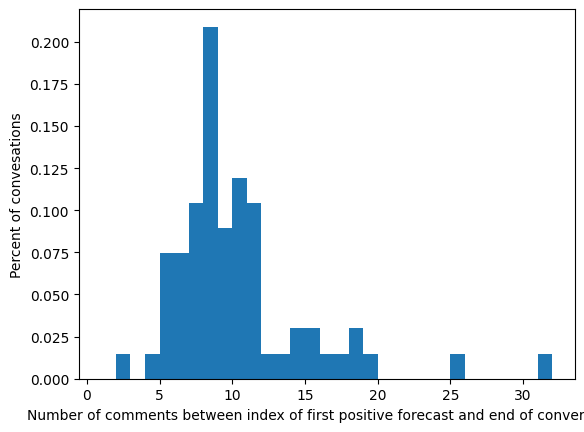

Processed 5101 context tuples for model evaluation
Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!
Iteration: 1; Percent complete: 1.2%
Iteration: 2; Percent complete: 2.5%
Iteration: 3; Percent complete: 3.8%
Iteration: 4; Percent complete: 5.0%
Iteration: 5; Percent complete: 6.2%
Iteration: 6; Percent complete: 7.5%
Iteration: 7; Percent complete: 8.8%
Iteration: 8; Percent complete: 10.0%
Iteration: 9; Percent complete: 11.2%
Iteration: 10; Percent complete: 12.5%
Iteration: 11; Percent complete: 13.8%
Iteration: 12; Percent complete: 15.0%
Iteration: 13; Percent complete: 16.2%
Iteration: 14; Percent complete: 17.5%
Iteration: 15; Percent complete: 18.8%
Iteration: 16; Percent complete: 20.0%
Iteration: 17; Percent complete: 21.2%
Iteration: 18; Percent complete: 22.5%
Iteration: 19; Percent complete: 23.8%
Iteration: 20; Percent complete: 25.0%
Iteration: 21; Percent complete: 26.2%
Iteration: 22; Percent complete: 27.5%
Ite

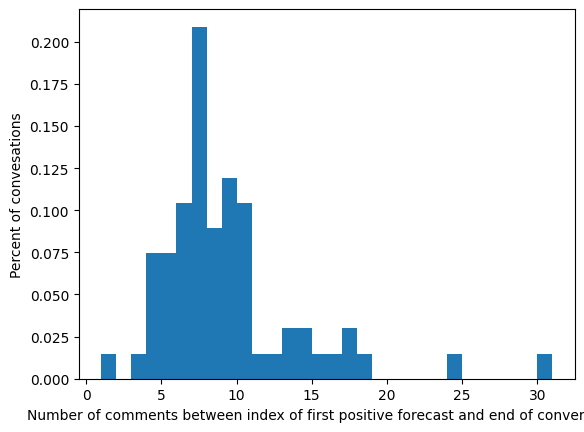

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 9.191176470588236, Median = 8.0


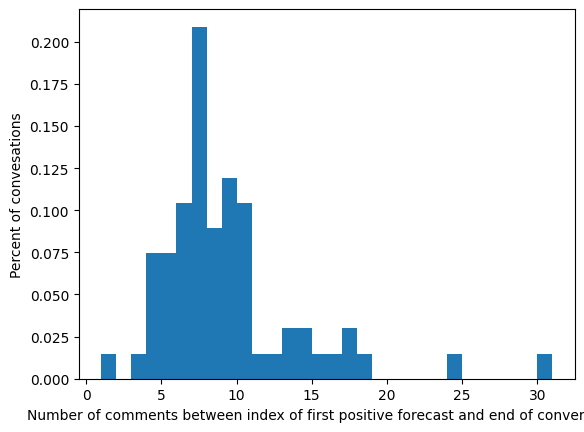

Processed 4656 context tuples for model evaluation
Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!
Iteration: 1; Percent complete: 1.4%
Iteration: 2; Percent complete: 2.7%
Iteration: 3; Percent complete: 4.1%
Iteration: 4; Percent complete: 5.5%
Iteration: 5; Percent complete: 6.8%
Iteration: 6; Percent complete: 8.2%
Iteration: 7; Percent complete: 9.6%
Iteration: 8; Percent complete: 11.0%
Iteration: 9; Percent complete: 12.3%
Iteration: 10; Percent complete: 13.7%
Iteration: 11; Percent complete: 15.1%
Iteration: 12; Percent complete: 16.4%
Iteration: 13; Percent complete: 17.8%
Iteration: 14; Percent complete: 19.2%
Iteration: 15; Percent complete: 20.5%
Iteration: 16; Percent complete: 21.9%
Iteration: 17; Percent complete: 23.3%
Iteration: 18; Percent complete: 24.7%
Iteration: 19; Percent complete: 26.0%
Iteration: 20; Percent complete: 27.4%
Iteration: 21; Percent complete: 28.8%
Iteration: 22; Percent complete: 30.1%
Ite

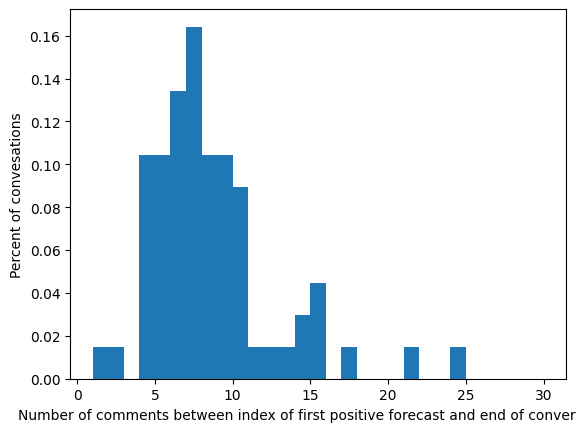

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 8.5, Median = 7.0


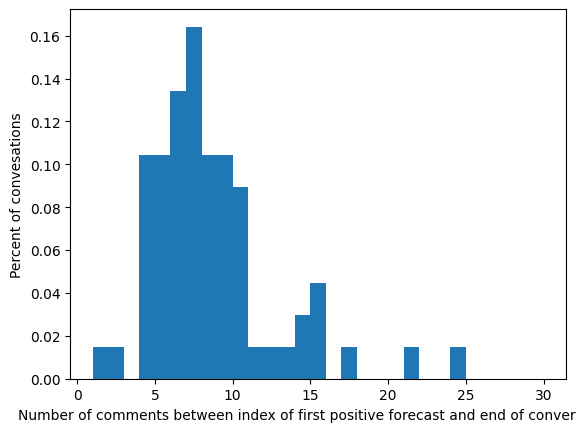

In [18]:

final_data = DataPreprocesser(filepath)
final_data_no_last = DataPreprocesser(filepath_no_last)
final_data_no_submit_last = DataPreprocesser(filepath_no_submit_last)

""" New Testing Corpus """
ground1 = corp.corpusBuilder(final_data) 
ground2= corp.corpusBuilder(final_data_no_last)
ground3=corp.corpusBuilder(final_data_no_submit_last)
add_convo_labels(ground1, final_data)
add_convo_labels(ground2, final_data)
add_convo_labels(ground3, final_data)
corpus_train_test_split(ground1)
corpus_train_test_split(ground2)
corpus_train_test_split(ground3)
"""Testing"""
corpus_kodis_ground_orig = forecaster_kodis_wiki.transform(ground1, transform_selector)
ground_wiki_df, ground_wiki_metrics = forecaster_kodis_wiki.summarize(corpus_kodis_ground_orig, convo_selector)
ground_wiki_horizon =forecaster_kodis_wiki._draw_horizon_plot(corpus_kodis_ground_orig, convo_selector)

corpus_kodis_ground_nl = forecaster_kodis_wiki.transform(ground2, transform_selector)
no_last_wiki_df, no_last_wiki_metrics = forecaster_kodis_wiki.summarize(corpus_kodis_ground_nl , convo_selector)
no_last_wiki_horizon = forecaster_kodis_wiki._draw_horizon_plot(corpus_kodis_ground_nl, convo_selector)

corpus_kodis_ground_nls = forecaster_kodis_wiki.transform(ground3, transform_selector)
no_last_submit_wiki_df, no_last_submit_wiki_metrics = forecaster_kodis_wiki.summarize(corpus_kodis_ground_nls,convo_selector)
no_last_submit_horizon = forecaster_kodis_wiki._draw_horizon_plot(corpus_kodis_ground_nls, convo_selector)

### Loading Artifacts Utilities

In [16]:
downpath =Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/downsampled_run")
defaultpath =Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/nosampling_run")
weights_path = Path("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/fine_tuning_results/weighted_run")
#/work/data/fine_tuning_results/nosampling/run_20250509_090059/corpus_kodis_ground_default

def load_artifact(exp_dir: Path, name: str):
    p = exp_dir / name
    if (p.with_suffix('.json')).exists():
        return json.loads((p.with_suffix('.json')).read_text())
    if (p.with_suffix('.csv')).exists():
        return pd.read_csv(p.with_suffix('.csv'))
    if p.is_dir():
        return Corpus(filename= str(p))
    if (p.with_suffix('.pt')).exists():
        return torch.load(p.with_suffix('.pt'))
    raise FileNotFoundError(f"No artifact {name} in {exp_dir}")

def load_all_variants(exp_dir: Path):
    # detect which naming scheme this folder uses
    if (exp_dir / "corpus_kodis_ground_downsampled").is_dir():
        variant = "downsampled"
    elif (exp_dir / "corpus_kodis_ground_weighted_loss").is_dir():
        variant = "weighted"
    else:
        variant = "default"

    # build name‐templates
    tpl = {
        "downsampled": {
            "ground_corpus":   "corpus_kodis_ground_downsampled",
            "ground_df":       "ground_downsampled_conv_df",
            "ground_metrics":  "ground_downsampled_metrics",
            "ground_horizon":  "ground_horizon_utterances",
            # "ground_chkpt":    "ground_downsampled",

            "no_last_corpus":  "corpus_kodis_no_last_downsampled",
            "no_last_df":      "nolast_downsampled_conv_df",
            "no_last_metrics": "no_last_downsampled_metrics",
            "no_last_horizon": "no_last_horizon_utterances",
            # "no_last_chkpt":   "no_last_downsampled",

            "no_subm_corpus":  "corpus_kodis_no_last_submit_downsampled",
            "no_subm_df":      "no_submit_last_downsampled_conv_df",
            "no_subm_metrics": "no_last_submit_downsampled_metrics",
            "no_subm_horizon": "no_last_submit_horizon_utterances",
            # "no_subm_chkpt":   "no_submit_last_downsampled",
        },
        "weighted": {
            "ground_corpus":   "corpus_kodis_ground_weighted_loss",
            "ground_df":       "ground_weight_conv_df",
            "ground_metrics":  "ground_weighted_metrics",
            "ground_horizon":  "ground_weight_horizon",
            # "ground_chkpt":    "ground_weighted",

            "no_last_corpus":  "corpus_kodis_no_last_weighted_loss",
            "no_last_df":      "nolast_weight_conv_df",
            "no_last_metrics": "no_last_weighted_metrics",
            "no_last_horizon": "no_last_weight_horizon",
            # "no_last_chkpt":   "no_last_weighted",

            "no_subm_corpus":  "corpus_kodis_no_submit_weighted_loss",
            "no_subm_df":      "no_submit_last_weight_conv_df",
            "no_subm_metrics": "no_last_submit_weighted_metrics",
            "no_subm_horizon": "no_last_submit_weight_horizon",
            # "no_subm_chkpt":   "no_submit_last_weighted",
        },
        "default": {
            "ground_corpus":   "corpus_kodis_ground_default",
            "ground_df":       "ground_conv_default_df",
            "ground_metrics":  "ground_default_metrics",
            "ground_horizon":  "ground_default_horizon",
            # "ground_chkpt":    "ground_default",

            "no_last_corpus":  "corpus_kodis_no_last_default",
            "no_last_df":      "no_last_conv_df_default",
            "no_last_metrics": "no_last_default_metrics",
            "no_last_horizon": "no_last_default_horizon",
            # "no_last_chkpt":   "no_last_default",

            "no_subm_corpus":  "corpus_kodis_no_submit_last_default",
            "no_subm_df":      "no_last_submit_conv_default_df",
            "no_subm_metrics": "no_last_submit_default_metrics",
            "no_subm_horizon": "no_last_submit_default_horizon",
            # "no_subm_chkpt":   "no_last_submit_last_default",
        },
    }[variant]

    return {
        key: load_artifact(exp_dir, fname)
        for key, fname in tpl.items()
    }


# Now load each regime:
down = load_all_variants(downpath)
no_samp = load_all_variants(defaultpath)
wt = load_all_variants(weights_path)

### Load Artifacts

In [21]:
wiki ={}
wiki["ground_corpus"] = corpus_kodis_ground_orig
wiki["ground_metrics"] = ground_wiki_metrics
wiki["ground_df"] =  ground_wiki_df
wiki["ground_horizon"] = ground_wiki_horizon

wiki["no_last_corpus"] = corpus_kodis_ground_nl
wiki["no_last_metrics"] = no_last_wiki_metrics
wiki["no_last_df"] =  no_last_wiki_df
wiki["no_last_horizon"] = no_last_wiki_horizon

wiki["no_last_submit_corpus"] = corpus_kodis_ground_nls
wiki["no_last_submit_metrics"] = no_last_submit_wiki_metrics
wiki["no_last_submit_df"] =  no_last_submit_wiki_df
wiki["no_last_submit_horizon"] = no_last_submit_horizon

wiki["ground_df"] = wiki["ground_df"].reset_index(drop=True)
wiki["no_last_df"] = wiki["no_last_df"].reset_index(drop=True)
wiki["no_last_submit_df"] = wiki["no_last_submit_df"].reset_index(drop=True)



corpora_info_ground = [
    (
        "GROUND_DEFAULT",
        no_samp   ["ground_corpus"],
        no_samp   ["ground_metrics"],
        no_samp   ["ground_df"],
        no_samp   ["ground_horizon"],
    ),
    (
        "GROUND_WEIGHTED",
        wt        ["ground_corpus"],
        wt        ["ground_metrics"],
        wt        ["ground_df"],
        wt        ["ground_horizon"],
    ),
    (
        "GROUND_DOWNSAMPLED",
        down      ["ground_corpus"],
        down      ["ground_metrics"],
        down      ["ground_df"],
        down      ["ground_horizon"],
    ),
    (
        "GROUND_WIKI",
        wiki      ["ground_corpus"],
        wiki      ["ground_metrics"],
        wiki      ["ground_df"],
        wiki      ["ground_horizon"],
    )
]

corpora_info_no_last = [
    (
        "NO_LAST_DEFAULT",
        no_samp["no_last_corpus"],
        no_samp["no_last_metrics"],
        no_samp["no_last_df"],
        no_samp["no_last_horizon"],
    ),
    (
        "NO_LAST_WEIGHTED",
        wt["no_last_corpus"],
        wt["no_last_metrics"],
        wt["no_last_df"],
        wt["no_last_horizon"],
    ),
    (
        "NO_LAST_DOWNSAMPLED",
        down["no_last_corpus"],
        down["no_last_metrics"],
        down["no_last_df"],
        down["no_last_horizon"],
    ),
    (
        "GROUND_WIKI",
        wiki      ["ground_corpus"],
        wiki      ["ground_metrics"],
        wiki      ["ground_df"],
        wiki      ["ground_horizon"],
    )
]


corpora_info_no_subm = [
    (
        "NO_LAST_SUBMIT_DEFAULT",
        no_samp["no_subm_corpus"],
        no_samp["no_subm_metrics"],
        no_samp["no_subm_df"],
        no_samp["no_subm_horizon"],
    ),
    (
        "NO_LAST_SUBMIT_WEIGHTED",
        wt["no_subm_corpus"],
        wt["no_subm_metrics"],
        wt["no_subm_df"],
        wt["no_subm_horizon"],
    ),
    (
        "NO_LAST_SUBMIT_DOWNSAMPLED",
        down["no_subm_corpus"],
        down["no_subm_metrics"],
        down["no_subm_df"],
        down["no_subm_horizon"],
    ), (
        "GROUND_WIKI",
        wiki      ["ground_corpus"],
        wiki      ["ground_metrics"],
        wiki      ["ground_df"],
        wiki      ["ground_horizon"],
    )
]

### Utterance Variants

In [22]:
corpora_info_downsampled = [
    (
        "GROUND_DOWNSAMPLED",
        down["ground_corpus"],
        down["ground_metrics"],
        down["ground_df"],
        down["ground_horizon"],
    ),
    (
        "NO_LAST_DOWNSAMPLED",
        down["no_last_corpus"],
        down["no_last_metrics"],
        down["no_last_df"],
        down["no_last_horizon"],
    ),
    (
        "NO_LAST_SUBMIT_DOWNSAMPLED",
        down["no_subm_corpus"],
        down["no_subm_metrics"],
        down["no_subm_df"],
        down["no_subm_horizon"],
    ),
    (
        "GROUND_WIKI",
        wiki      ["ground_corpus"],
        wiki      ["ground_metrics"],
        wiki      ["ground_df"],
        wiki      ["ground_horizon"],
    )
]
corpora_info_weighted = [
    (
        "GROUND_WEIGHTED",
        wt["ground_corpus"],
        wt["ground_metrics"],
        wt["ground_df"],
        wt["ground_horizon"],
    ),
    (
        "NO_LAST_WEIGHTED",
        wt["no_last_corpus"],
        wt["no_last_metrics"],
        wt["no_last_df"],
        wt["no_last_horizon"],
    ),
    (
        "NO_LAST_SUBMIT_WEIGHTED",
        wt["no_subm_corpus"],
        wt["no_subm_metrics"],
        wt["no_subm_df"],
        wt["no_subm_horizon"],
    ),
    (
        "GROUND_WIKI",
        wiki      ["ground_corpus"],
        wiki      ["ground_metrics"],
        wiki      ["ground_df"],
        wiki      ["ground_horizon"],
    )
]
corpora_info_no_sampling = [
    (
        "DEFAULT_NOSAMP",
        no_samp["ground_corpus"],
        no_samp["ground_metrics"],
        no_samp["ground_df"],
        no_samp["ground_horizon"],
    ),
    (
        "NO_LAST_NOSAMP",
        no_samp["no_last_corpus"],
        no_samp["no_last_metrics"],
        no_samp["no_last_df"],
        no_samp["no_last_horizon"],
    ),
    (
        "NO_LAST_SUBMIT_NOSAMP",
        no_samp["no_subm_corpus"],
        no_samp["no_subm_metrics"],
        no_samp["no_subm_df"],
        no_samp["no_subm_horizon"],
    ),
    (
        "GROUND_WIKI",
        wiki      ["ground_corpus"],
        wiki      ["ground_metrics"],
        wiki      ["ground_df"],
        wiki      ["ground_horizon"],
    )
]